# Personalized Banking - Santander Product Recommendation

**Group 15:** Constantin Baumann (49620), Clara Börner (44427), Sherwin Husseinifard (50568), Jens Gabriel Kohl (48414), Leonie Mostbeck (49238)



# Introduction

#### From the business problem...


With markets becoming fiercer and more competitive, customers now require and demand a higher level of personalization with each and every product. Those personal recommendations are an especially crucial tool in markets with a myriad of offers as they help the customer navigate the multitude of possibilities and can nudge them into a purchase they otherwise would not have done. 

Banco Santander is a retail and commercial bank based in Spain. They offer a variety of products, ranging from simple credit cards and loans to mortgages and long-term deposits. With its current recommendation system only a small number of customers receive many recommendations while the majority of customers do not receive any. Consequently, this creates a disparity in customer experiences and makes the company lose out on financial rewards from having satisfied customers with more products. 

The goal would be a better recommendation system that helps Santander to do a better job in advertising services to its customers so that they are more likely to add and use their financial products - resulting not only in saving Santander money, but also providing a better customer experience overall. To achieve this, Santander seeks to use its available data and implement machine learning algorithms - but does this actually make sense? 



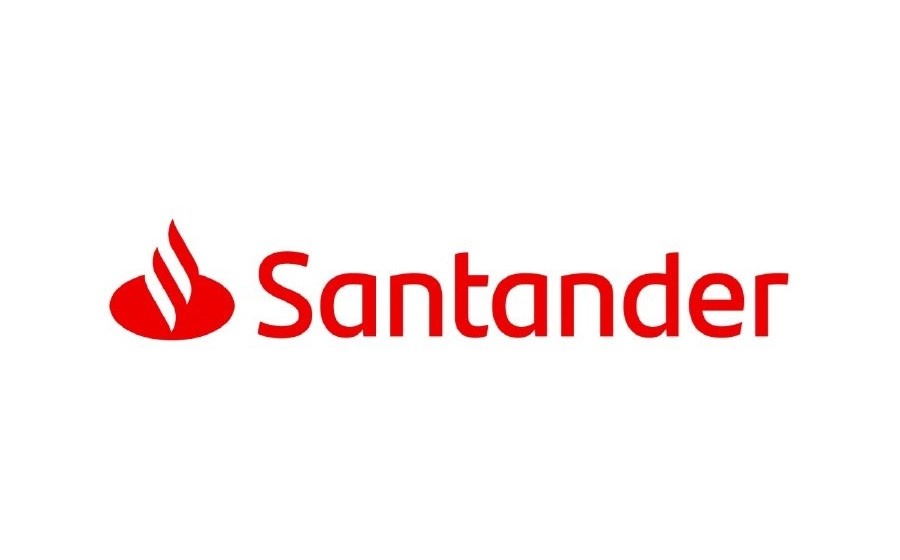

#### ... to the machine learning problem

Just like before starting any machine learning model, us - the business analytics team - got together and looked closer at the business context: 


*   We first have to determine whether machine learning could help Santandar with its business objective. Building a new recommendation system requires a lot of automation and is a high volume task with complex rules, so that ML would help navigate this.
*   Thus, we can formulate clearly: given the data available (discussed in detail further down), which gives us demographic as well as product purchase information, we want to predict the probabilty that each customer will add a new product (if any). This should help to the bank to offer financial products to its customers they will actually use and like in the future.  
*   Our dataset consists of data about customers, their demographics and purchased banking products per month from January 2015 to May 2016 with the goal to predict which products the customers would purchase in June 2016. Each row represents one customer in one month. We thus have labeled data and purchasing pattern, which can help us formulate a classification problem.Accordingly, we will create, train and validate the model on the data from Jan 2015 to May 2016 and finally execute that model on the data from June 2016. For each product the customer previously did not own, we want to compute whether or not this customer will subscribe to it in the next month. After sorting them, the **top-3** products will be recommended to the customer. We will recommend only 3 products as we want to make sure that those products, would really be a fit for the customer and thus, a larger number would not make sense in this context. 
*   The ultimate outcome would not only be an optimized machine learning model with minimized errors that performs well but also that it serves its purpose in the business context to improve customer experience and increase customer satisfaction, finally resulting in increased profitability for Santander. 

So, after having identified from our business problem a machine learning problem, how do we further proceed? 

### Outline:

We we also want to clean the data so that we use only what is necessary for the problem at hand. In our case, we only need to look at accounts that have actually added products in the past (which happens to be a rare event) so that we then can reduce the dataset's size and increase speed and training time. Then we are going to conduct a comprehensive data exploration and visualization to better understand the given data.

After that we progress with feature engineering and model selection: The recommendations are then eventually based on gradient boosted classification tree algorithm called "XGBoost" (we have tried another model "Scikit-MultiLearn BinaryRelevance", which did not work that well before). This algorithm builds many simple models, aka weak learners, and learns from the mistakes of the previous ones by reweighting the input data. The output of the XGBoost model is a combination of all the predictions made by the many weak models before. 

We will use cross-validation and gridsearchCV/RandomizedsearcCV to find the model that performs best on different data folds. We will try different configurations of features, weighting, etc. and then choose the one that performed best to showcase it here. The evaluation metric we used to identify is then precision (for each product´s classifcation and mean average of top 3) as we wanted to reward the solution where the person actually added one of the items we recommend. As it is not our goal to predict if someone will buy something or not, we want to recommend the products with the highest likelihood to be bought (because a purchase is relatively rare, the probabilities are very small).  

We then revisit the business problem and evaluate whether our consequent machine learning model serves its purpose.



# 1. Import the necessary libraries, load data & initial exploration

In [ ]:
# Load packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6) 
import warnings
warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


Now that our packages are loaded, let’s read in and take a look at the data.
We seperatly read in the data from January 2015 to Mai 2016 and June 2016. Further, since the df is rather larger we limit the size by sampling 20% of unique IDs and filter both df with the resulting list of IDs. 

In [ ]:
import os
os.getcwd()

from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
df           = pd.read_csv('/drive/MyDrive/ML_GROUP_WORK/data/train_df.csv',
                           dtype={"sexo":str, "ind_nuevo":str, 
                                 "ult_fec_cli_1t":str, 
                                  "indext":str})

df_june =  pd.read_csv('/drive/MyDrive/ML_GROUP_WORK/data/test_df.csv',
                           dtype={"sexo":str, "ind_nuevo":str, 
                                 "ult_fec_cli_1t":str, 
                                  "indext":str})

unique_ids   = pd.Series(df["ncodpers"].unique())
df           = df[df.ncodpers.isin(unique_ids)]

df_june          = df_june[df_june.ncodpers.isin(unique_ids)]

In [ ]:
print(f'Length of train data: {len(df)}')
print(f'Length of test data: {len(df_june)}')

Length of train data: 13647309
Length of test data: 929615


In [ ]:
unique_id    = unique_ids.sample(frac = 0.2)
df           = df[df.ncodpers.isin(unique_id)]
df_june      = df_june[df_june.ncodpers.isin(unique_id)]

In [ ]:
df.describe()

,ncodpers,indrel,tipodom,cod_prov,ind_actividad_cliente,renta,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
count,2.731532e+06,2.726132e+06,2726132.0,2.712524e+06,2.726132e+06,2.171513e+06,2.731532e+06,2.731532e+06,2.731532e+06,2.731532e+06,...,2.731532e+06,2.731532e+06,2.731532e+06,2.731532e+06,2.731532e+06,2.731532e+06,2.731532e+06,2.728423e+06,2.728423e+06,2.731532e+06
mean,8.358887e+05,1.173451e+00,1.0,2.663499e+01,4.571345e-01,1.335344e+05,8.566621e-05,3.441292e-05,6.567465e-01,4.481002e-04,...,6.130992e-03,8.943699e-03,2.616114e-03,5.303873e-02,4.443587e-02,2.562262e-02,3.909162e-03,5.426505e-02,5.890912e-02,1.270558e-01
std,4.307286e+05,4.119236e+00,0.0,1.277885e+01,4.981593e-01,2.116599e+05,9.255210e-03,5.866153e-03,4.747954e-01,2.116364e-02,...,7.806026e-02,9.414729e-02,5.108103e-02,2.241108e-01,2.060615e-01,1.580067e-01,6.240097e-02,2.265400e-01,2.354546e-01,3.330355e-01
min,1.589400e+04,1.000000e+00,1.0,1.000000e+00,0.000000e+00,1.202730e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.553960e+05,1.000000e+00,1.0,1.500000e+01,0.000000e+00,6.870606e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.320160e+05,1.000000e+00,1.0,2.800000e+01,0.000000e+00,1.019020e+05,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.199361e+06,1.000000e+00,1.0,3.500000e+01,1.000000e+00,1.561478e+05,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.553686e+06,9.900000e+01,1.0,5.200000e+01,1.000000e+00,2.889440e+07,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [ ]:
df_june.describe()

,ncodpers,age,antiguedad,indrel,indrel_1mes,tipodom,cod_prov,ind_actividad_cliente
count,1.860410e+05,186041.000000,186041.000000,186041.000000,186037.000000,186041.0,185216.000000,186041.000000
mean,8.804576e+05,40.236249,80.785074,1.185421,1.000043,1.0,26.607275,0.424079
std,4.473102e+05,17.178272,67.057267,4.258758,0.009274,0.0,12.830651,0.494204
min,1.589400e+04,2.000000,0.000000,1.000000,1.000000,1.0,1.000000,0.000000
25%,4.858130e+05,25.000000,23.000000,1.000000,1.000000,1.0,15.000000,0.000000
50%,9.666930e+05,38.000000,55.000000,1.000000,1.000000,1.0,28.000000,0.000000
75%,1.263724e+06,51.000000,135.000000,1.000000,1.000000,1.0,35.000000,1.000000
max,1.553686e+06,117.000000,257.000000,99.000000,3.000000,1.0,52.000000,1.000000


*The given Santander Product Recommendation dataset presents us a number of demographics for each individual as well as the products they currently own.*

For more detailed information about the given data fields, please check out the following page: https://www.kaggle.com/competitions/santander-product-recommendation/data

# 2. Data Cleaning
Before we jump into the data exploration/visualization to understand the customer behaviour better, let's do some initial data cleaning for both df when necassary

In [ ]:
# How many records do we have in our dataset?
print("We have total number of records of:", df["ncodpers"].count())

We have total number of records of: 2731532


Let's also check which datatypes we have throughout our dataset and whether we have to make some adjustments.

In [ ]:
df.dtypes

fecha_dato                object
ncodpers                   int64
ind_empleado              object
pais_residencia           object
sexo                      object
age                       object
fecha_alta                object
ind_nuevo                 object
antiguedad                object
indrel                   float64
ult_fec_cli_1t            object
indrel_1mes               object
tiprel_1mes               object
indresi                   object
indext                    object
conyuemp                  object
canal_entrada             object
indfall                   object
tipodom                  float64
cod_prov                 float64
nomprov                   object
ind_actividad_cliente    float64
renta                    float64
segmento                  object
ind_ahor_fin_ult1          int64
ind_aval_fin_ult1          int64
ind_cco_fin_ult1           int64
ind_cder_fin_ult1          int64
ind_cno_fin_ult1           int64
ind_ctju_fin_ult1          int64
ind_ctma_f

In [ ]:
df_june.dtypes

fecha_dato                object
ncodpers                   int64
ind_empleado              object
pais_residencia           object
sexo                      object
age                        int64
fecha_alta                object
ind_nuevo                 object
antiguedad                 int64
indrel                     int64
ult_fec_cli_1t            object
indrel_1mes              float64
tiprel_1mes               object
indresi                   object
indext                    object
conyuemp                  object
canal_entrada             object
indfall                   object
tipodom                    int64
cod_prov                 float64
nomprov                   object
ind_actividad_cliente      int64
renta                     object
segmento                  object
dtype: object

Some datatypes seem a bit odd. Let's also make some initial adjustments. More on that comes later in the feature engineering part. 

In [ ]:
# Change datatype
df["age"]   = pd.to_numeric(df["age"], errors="coerce") 
df["antiguedad"]   = pd.to_numeric(df["antiguedad"], errors="coerce") 
df["indrel_1mes"]   = pd.to_numeric(df["indrel_1mes"], errors="coerce") 

In [ ]:
df_june["age"]   = pd.to_numeric(df_june["age"], errors="coerce") 
df_june["antiguedad"]   = pd.to_numeric(df_june["antiguedad"], errors="coerce") 
df_june["indrel_1mes"]   = pd.to_numeric(df_june["indrel_1mes"], errors="coerce") 
df_june["renta"]   = pd.to_numeric(df_june["renta"], errors="coerce") 

Now let's move on to look at the missing data in our dataset - is there any? 

In [ ]:
# Missing values per column
df.isnull().sum()

fecha_dato                     0
ncodpers                       0
ind_empleado                5400
pais_residencia             5400
sexo                        5417
age                         5400
fecha_alta                  5400
ind_nuevo                   5400
antiguedad                  5400
indrel                      5400
ult_fec_cli_1t           2726707
indrel_1mes                29963
tiprel_1mes                29779
indresi                     5400
indext                      5400
conyuemp                 2731091
canal_entrada              37118
indfall                     5400
tipodom                     5400
cod_prov                   19008
nomprov                    19008
ind_actividad_cliente       5400
renta                     560019
segmento                   37833
ind_ahor_fin_ult1              0
ind_aval_fin_ult1              0
ind_cco_fin_ult1               0
ind_cder_fin_ult1              0
ind_cno_fin_ult1               0
ind_ctju_fin_ult1              0
ind_ctma_f

In [ ]:
# Missing values per column
df_june.isnull().sum()

fecha_dato                    0
ncodpers                      0
ind_empleado                  0
pais_residencia               0
sexo                          1
age                           0
fecha_alta                    0
ind_nuevo                     0
antiguedad                    0
indrel                        0
ult_fec_cli_1t           185689
indrel_1mes                   4
tiprel_1mes                   4
indresi                       0
indext                        0
conyuemp                 186014
canal_entrada               422
indfall                       0
tipodom                       0
cod_prov                    825
nomprov                     825
ind_actividad_cliente         0
renta                     45636
segmento                    460
dtype: int64

There are many columns with missing values. 
However, the two columns "ult_fec_cli_1t" & "conyuemp" miss almost all values. We are going to delete them directly from the dataframe.

In [ ]:
# Drop the columns
df = df.drop(["ult_fec_cli_1t", "conyuemp"], axis=1) 

In [ ]:
df_june = df_june.drop(["ult_fec_cli_1t", "conyuemp"], axis=1) 

Also, the column "renta" (= income) contains a lot of missing values. As we assume that this column is important, let's replace the missing values in the income column by the average income of the customers in the same province. 

Since the relative number of for the remaining missing variables in our dataset is relatively low, we are going to drop any missing values in the these other variables. 

In [ ]:
grouped        = df.groupby("nomprov").agg({"renta":lambda x: x.median(skipna=True)}).reset_index()
new_incomes    = pd.merge(df,grouped,how="inner",on="nomprov").loc[:, ["nomprov","renta_y"]]
new_incomes    = new_incomes.rename(columns={"renta_y":"renta"}).sort_values("renta").sort_values("nomprov")
df.sort_values("nomprov",inplace=True)
df             = df.reset_index()
new_incomes    = new_incomes.reset_index()

df.loc[df.renta.isnull(),"renta"] = new_incomes.loc[df.renta.isnull(),"renta"].reset_index()
df.loc[df.renta.isnull(),"renta"] = df.loc[df.renta.notnull(),"renta"].median()
df.sort_values(by="fecha_dato",inplace=True)

In [ ]:
grouped        = df_june.groupby("nomprov").agg({"renta":lambda x: x.median(skipna=True)}).reset_index()
new_incomes    = pd.merge(df_june,grouped,how="inner",on="nomprov").loc[:, ["nomprov","renta_y"]]
new_incomes    = new_incomes.rename(columns={"renta_y":"renta"}).sort_values("renta").sort_values("nomprov")
df_june.sort_values("nomprov",inplace=True)
df_june             = df_june.reset_index()
new_incomes    = new_incomes.reset_index()

df_june.loc[df.renta.isnull(),"renta"] = new_incomes.loc[df_june.renta.isnull(),"renta"].reset_index()
df_june.loc[df.renta.isnull(),"renta"] = df_june.loc[df_june.renta.notnull(),"renta"].median()
df_june.sort_values(by="fecha_dato",inplace=True)

Drop all the other missing values

In [ ]:
df = df.dropna(axis=0)

In [ ]:
df_june = df_june.dropna(axis=0)

There are some customers with seniority less than zero. We will replace with 0

In [ ]:
df[df["antiguedad"]<0] = 0

In [ ]:
df_june[df_june["antiguedad"]<0] = 0

Let's add a new column of the total number of products per customer per month. That could give us valuable insights later on. 


In [ ]:
df["tot_products"] = df.loc[:,"ind_ahor_fin_ult1":"ind_recibo_ult1"].sum(axis=1)
df["tot_products"]   = pd.to_numeric(df["tot_products"], errors="coerce") 

Now we will check customer distribution by country

In [ ]:
df['pais_residencia'].describe() 

count     2679917
unique          3
top            ES
freq      2679883
Name: pais_residencia, dtype: object

Almost all observations were acquired from country "ES".                                                                              Since other observations are so few in numbers, we'll drop them to have a focussed dataset. 

In [ ]:
df = df.loc[lambda df: df.pais_residencia == "ES", :]

In [ ]:
df_june = df_june.loc[lambda df_june: df_june.pais_residencia == "ES", :]

How about employee index?

In [ ]:
df['ind_empleado'].value_counts()

N    2678211
B        742
A        527
F        403
Name: ind_empleado, dtype: int64

Almost all obervations have come from non employees "N". As we want to focus on the most important features, we are going to exclude the other observations. 

In [ ]:
df = df.loc[lambda df: df.ind_empleado == "N", :]

In [ ]:
df_june = df_june.loc[lambda df_june: df_june.ind_empleado == "N", :]

**We've now cleaned and trimmed down the Santander dataset to its most important core data.**

**Let's now explore Santander's customers by looking at a few different metrices.** 

# 3. Data Exploration & Visualization ##
Since the dataset is still very abstract and we only collected high-level information so far, we now want to learn more about our customers. To do this, we will now look at various metrics that will later help us model an optimized product recommendation algorithm. 

*To keep an overview, we recommend to unfold and fold (use the toggle fuction) the following data visualization.*

##### What age are Santander's customers?

**Let's start very basic by answering the question how old Santander's customers are. We are going to use a detailled histogram to get a broader piture.**

Text(0, 0.5, 'Number of customers')

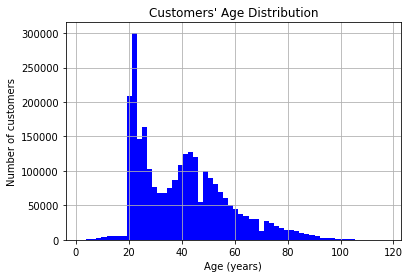

In [ ]:
df['age'].hist(bins=60, color="Blue")
plt.title("Customers' Age Distribution")
plt.xlabel("Age (years)")
plt.ylabel("Number of customers") 


We can observe that the age distribution is bimodal. There are a large number of university-aged students, and then another peak around middle-age. What also pops up is that there are people with very small and very high ages. 


##### By which channels where the customers attracted?
**We now know which age our customers are. Also, from the data cleaning we know that most of the customers are located in Spain. But let's go one step back: How did these people actually become customers? Through which channels were these customers attracted to join?**

In [ ]:
# Customers count by channel 
df['canal_entrada'].value_counts().head(15)

KHE    812780
KAT    643799
KFC    618094
KHQ    119633
KFA     80906
KHK     47358
KHM     36201
KHN     23186
KHD     22709
KAS     17403
RED     15190
KAG     14312
KAY     13556
KAA     13228
KAB     12328
Name: canal_entrada, dtype: int64

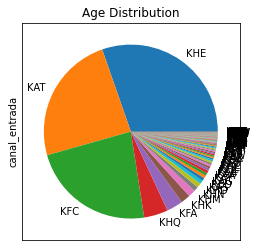

In [ ]:
df["canal_entrada"].value_counts().plot(x=None, y=None, kind='pie')
plt.title("Age Distribution")
plt.box()

The majority of customers have joined through three major channels.

##### When did the customers joined?
**Before diving into more specific numbers who uses which products, let us take a look when Santander's customers joined. Did the majority just recenlty joined or have they been customers for a while (> six months)?** 

In [ ]:
df_a = df.groupby(['ind_nuevo'])['tot_products'].agg('count') 
df_a

ind_nuevo
 0    2543480
 1     134731
Name: tot_products, dtype: int64

Most customers are recurrent customers, older than six months. Only a minor proportion joined during the past six months.

##### Number of customers by total number of products owned

**So we have seen that the most clients got customers via three channels and have joined more than six months ago. Now let's take a look and see how they "evolved" as a customer. How many of Santander's products do the most customer own?** 

In [ ]:
# Extract number of customers by total number of products owned
df_a = df["tot_products"].value_counts()
df_a = pd.DataFrame(df_a)

In [ ]:
df["ncodpers"].count()

2678211

In [ ]:
# calculate the percentage of customers using different number of products
count = df["ncodpers"].count()
df_a["percentage"] = (df_a["tot_products"]/count)*100
df_a

,tot_products,percentage
1.0,1411451,52.701262
0.0,489617,18.281495
2.0,381504,14.244733
3.0,154225,5.758508
4.0,89017,3.323749
5.0,58018,2.166297
6.0,41391,1.545472
7.0,28537,1.065525
8.0,14585,0.544580
9.0,6596,0.246284


Almost 80% of the customers own one or two products. Only a minority (around 5%) uses more than five products. Also, there are some "deadbeats" (= people that own NO product, around 18%) that are signed up as a customer but do not use any product at all. Now let's explore which product is the most used one. 

##### Number of products by activity index and sex
**Most people only use up to three products (including None). But let's get a bit more specific. Are the customers of our products active users or do the just "have" our product but not using it? Is there also a difference between genders recognizable?**


In [ ]:
df_a = df.loc[:, ['sexo', 'ind_actividad_cliente']].join(df.loc[:, "ind_ahor_fin_ult1": "ind_recibo_ult1"])
df_a = df_a.groupby(['sexo', 'ind_actividad_cliente']).sum()
df_a = df_a.T

In [ ]:
df_a.head(10)

sexo                          H                   V          
ind_actividad_cliente       0.0       1.0       0.0       1.0
ind_ahor_fin_ult1          11.0      51.0      34.0     138.0
ind_aval_fin_ult1           0.0      12.0       0.0      82.0
ind_cco_fin_ult1       438340.0  390834.0  414735.0  521696.0
ind_cder_fin_ult1          51.0     157.0      51.0     944.0
ind_cno_fin_ult1         1256.0   89865.0    1638.0  126569.0
ind_ctju_fin_ult1        2301.0   10032.0    2546.0   10628.0
ind_ctma_fin_ult1        2028.0    8324.0    3514.0   12749.0
ind_ctop_fin_ult1       42876.0   89198.0   69620.0  145410.0
ind_ctpp_fin_ult1        8570.0   36804.0   12180.0   59299.0
ind_deco_fin_ult1         203.0    1853.0     276.0    2175.0

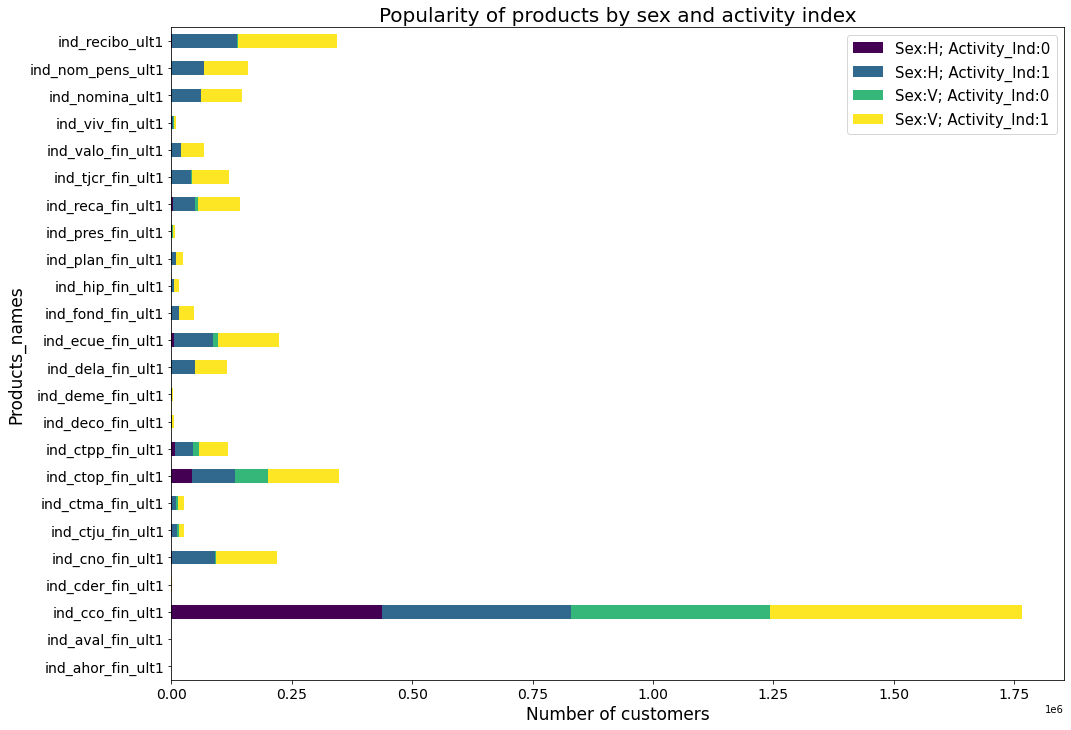

In [ ]:
df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='viridis')
plt.title('Popularity of products by sex and activity index', fontsize=20) 
plt.xlabel('Number of customers', fontsize=17) 
plt.ylabel('Products_names', fontsize=17) 
plt.legend(["Sex:H; Activity_Ind:0", "Sex:H; Activity_Ind:1", "Sex:V; Activity_Ind:0", 
            "Sex:V; Activity_Ind:1"], prop={'size':15}) 

Most of the customers used only one product which is the current account. Also, the split between the genders and active/inactive accounts is relatively even. In order to investigate the other products, let's exclude the dominant product (current account).

In [ ]:
# excluding the dominant product 
exclude = ['ind_cco_fin_ult1']
df_a = df_a.T
df_a = df_a.drop(exclude, axis=1).T

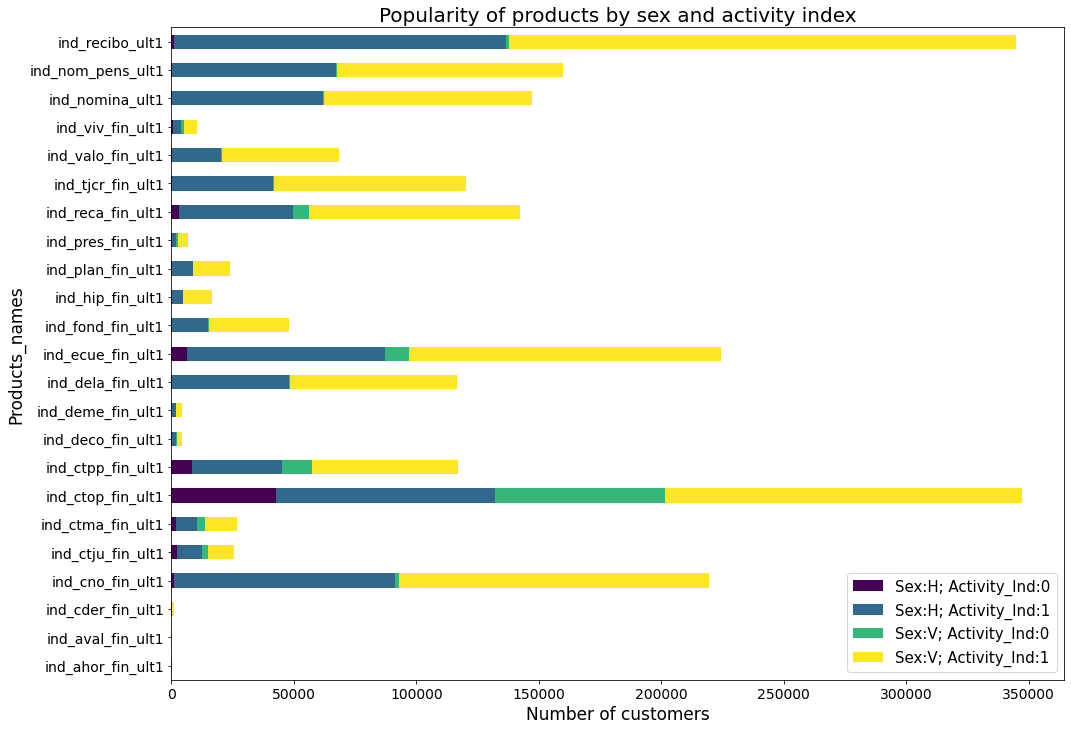

In [ ]:
df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='viridis')
plt.title('Popularity of products by sex and activity index', fontsize=20, color='black') 
plt.xlabel('Number of customers', fontsize=17, color='black') 
plt.ylabel('Products_names', fontsize=17, color='black') 
plt.legend(["Sex:H; Activity_Ind:0", "Sex:H; Activity_Ind:1", "Sex:V; Activity_Ind:0", 
            "Sex:V; Activity_Ind:1"], prop={'size':15}) 

By excluding the current account, we can observe that "ind_cno_fin_ult1" (Payroll Account), "ind_recibo_ult1" (Direct Debit), and "ind_ecue_fin_ult1" (e-account) are the three most popular products after the current accounts. 
However, and even more important, we can oberserve that the products have drastically less inactive users. By that we can follow that the "currents accounts" is a product with many "deadbeats".

##### Can we observe any specific patterns when it comes to the age?
**At the beginning of the data visualization we have seen that the age distribution is bimodal - meaning we have peaks for university-aged students and mid-aged people. But this was just to see who are our customers. We now want to see who is using/owning our products. Is any particular "age group" owning more than an other?** 

**Let's look first a basic absolute numbers. Are there specific ages when customers own the most total products?**

In [ ]:
df_a = df.groupby(['age'])['tot_products'].agg('sum')
df_a.sort_values(ascending=False).head(20)

age
23.0    145140.0
24.0    140034.0
22.0    129876.0
44.0    128212.0
45.0    126777.0
43.0    123944.0
46.0    120601.0
42.0    119282.0
41.0    117469.0
21.0    111470.0
47.0    111231.0
48.0    104195.0
40.0    102188.0
49.0     95955.0
25.0     94265.0
50.0     91346.0
39.0     89417.0
51.0     83176.0
52.0     80185.0
53.0     77062.0
Name: tot_products, dtype: float64

Text(0, 0.5, 'Number of products')

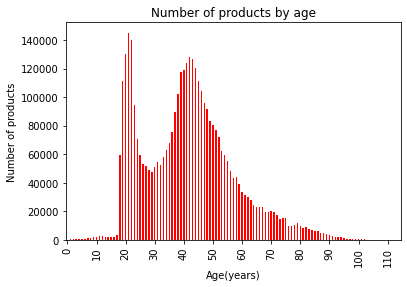

In [ ]:
# Number of products by age 
df_a.plot(kind='bar', colormap='autumn', legend=None) 
plt.xticks(np.arange(0, 120, 10), [str(x) for x in np.arange(0, 120, 10)])
plt.title('Number of products by age') 
plt.xlabel('Age(years)') 
plt.ylabel('Number of products') 

As already stated, we have a bimodal situation. But when compared to the plot at the beginning, we can recognize that middle-age people tend to own more products than younger people. Let's dive a bit deeper into that and try to even better understand the relation between age and the use of our products.

**Let us now cluster our customers into different age groups**

In [ ]:
# Let's create age groups
df_a = (df.groupby(pd.cut(df['age'], [0,20,40,60,80,100, pd.np.inf], right=False))
                     .sum())

In [ ]:
# Show aggregated dataset
df_a

,index,ncodpers,age,antiguedad,indrel,indrel_1mes,tipodom,cod_prov,ind_actividad_cliente,renta,...,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,tot_products
age,,,,,,,,,,,,,,,,,,,,,
"[0.0, 20.0)",186876629644,22906002854,390704.0,2533131.0,34433.0,29047.0,29043.0,795292.0,21451.0,4.380609e+09,...,0,0,57,0,0,0,31.0,117.0,4,26815.0
"[20.0, 40.0)",9353849236454,1490890911357,36212967.0,51294426.0,1555868.0,1348900.0,1348892.0,35058063.0,488871.0,1.530847e+11,...,1139,1163,33401,21636,7352,2108,49712.0,50483.0,119439,1524093.0
"[40.0, 60.0)",6283805610512,532559787252,44840581.0,112302053.0,1042294.0,935968.0,935964.0,25418592.0,544613.0,1.250767e+11,...,18132,4621,90871,82283,44806,8034,89896.0,92151.0,190481,1822037.0
"[60.0, 80.0)",1930469398170,148285231946,19348337.0,36332136.0,318946.0,285431.0,285430.0,7837584.0,139888.0,4.350595e+10,...,4620,880,15901,15718,13654,408,7593.0,15374.0,30822,461766.0
"[80.0, 100.0)",514112416606,35219142488,6545217.0,10329106.0,91516.0,75936.0,75934.0,2144114.0,32851.0,1.164218e+10,...,60,72,2042,675,2616,63,170.0,1917.0,4054,103956.0
"[100.0, inf)",20800784004,1072127790,304605.0,463120.0,3830.0,2948.0,2948.0,80871.0,614.0,4.510608e+08,...,0,17,58,17,22,0,0.0,7.0,42,2783.0


In [ ]:
# Keep the products columns and discard the others
df_a = df_a.loc[:, "ind_ahor_fin_ult1": "ind_recibo_ult1"]
df_a = df_a.T

In [ ]:
df_a.head(10)

age,"[0.0, 20.0)","[20.0, 40.0)","[40.0, 60.0)","[60.0, 80.0)","[80.0, 100.0)","[100.0, inf)"
ind_ahor_fin_ult1,0.0,0.0,231.0,3.0,0.0,0.0
ind_aval_fin_ult1,0.0,17.0,77.0,0.0,0.0,0.0
ind_cco_fin_ult1,1303.0,1020965.0,538792.0,162852.0,40619.0,1074.0
ind_cder_fin_ult1,0.0,137.0,758.0,257.0,51.0,0.0
ind_cno_fin_ult1,0.0,76274.0,121136.0,19658.0,2247.0,13.0
ind_ctju_fin_ult1,25258.0,249.0,0.0,0.0,0.0,0.0
ind_ctma_fin_ult1,0.0,9069.0,13351.0,3420.0,763.0,12.0
ind_ctop_fin_ult1,0.0,36574.0,207127.0,75077.0,26946.0,1380.0
ind_ctpp_fin_ult1,0.0,19327.0,76556.0,17476.0,3476.0,18.0
ind_deco_fin_ult1,0.0,1198.0,2366.0,745.0,198.0,0.0


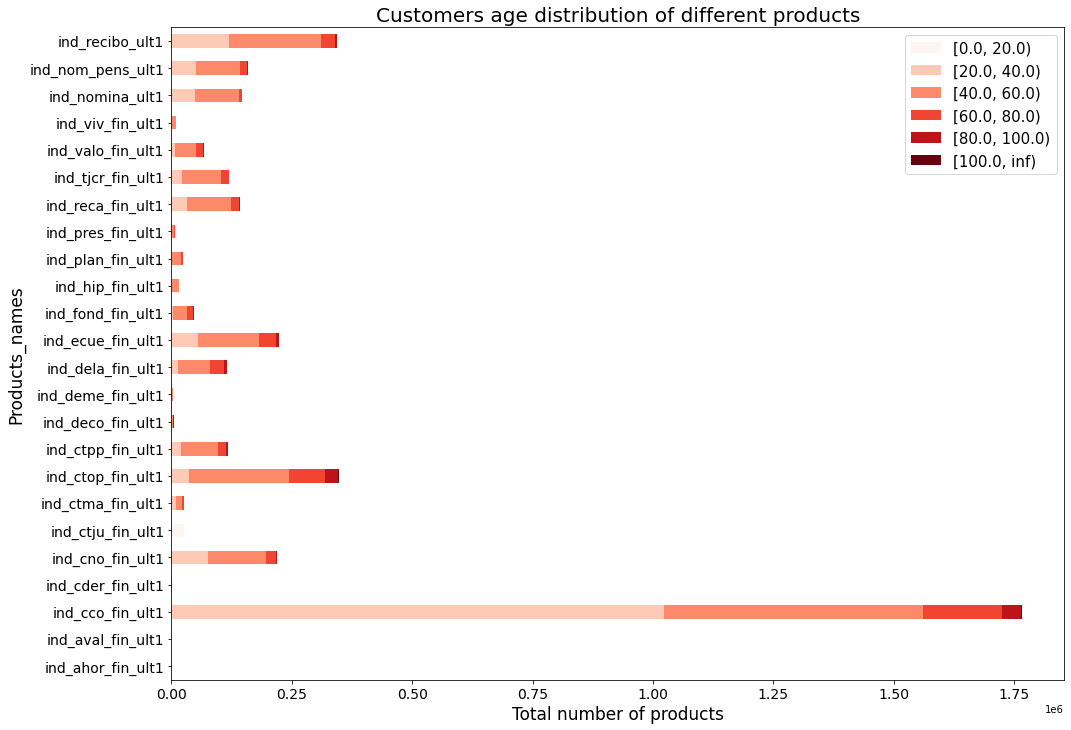

In [ ]:
# Plot of customers' age distibution of each product 
df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='Reds')
plt.title('Customers age distribution of different products', fontsize=20, color='black') 
plt.xlabel('Total number of products', fontsize=17, color='black') 
plt.ylabel('Products_names', fontsize=17, color='black') 
plt.legend(prop={'size':15}, loc=1) 

Again let's exclude the dominant product

In [ ]:
# exclude the dominant product "ind_cco_fin_ult1"
exclude = ['ind_cco_fin_ult1']
df_a = df_a.T
df_a = df_a.drop(exclude, axis=1).T

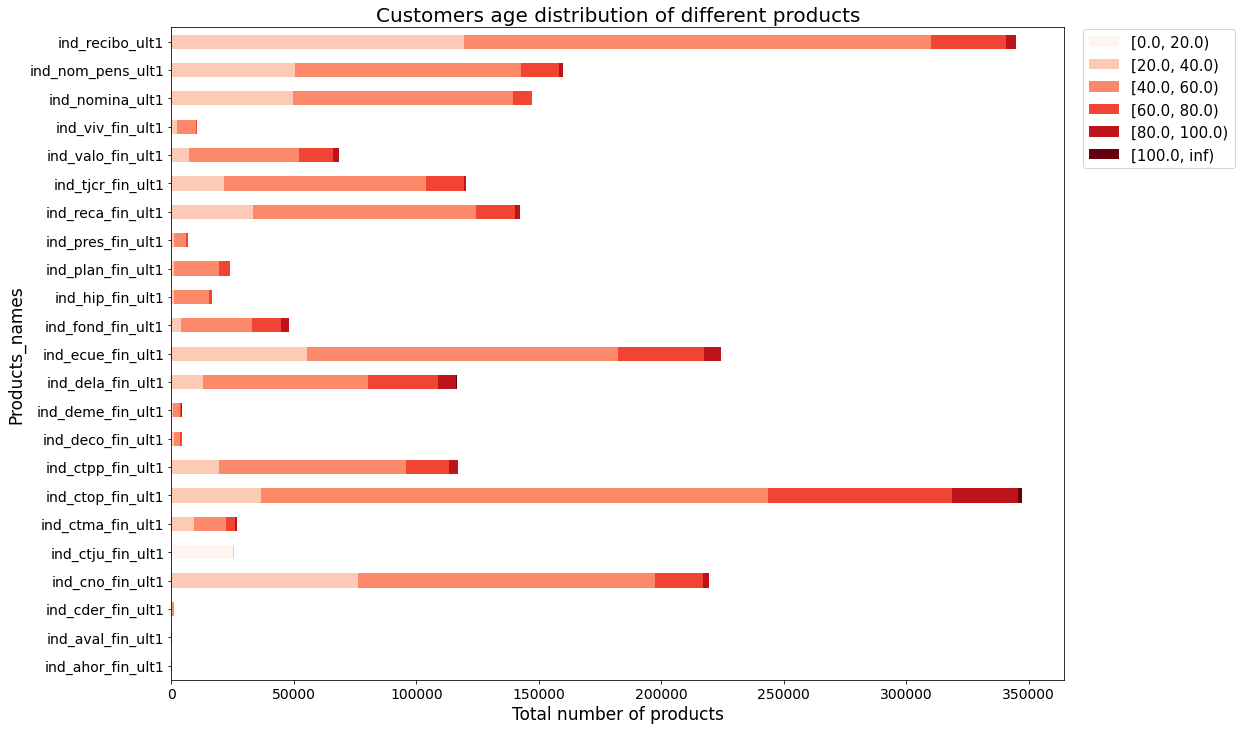

In [ ]:
# Plot of customers' age distibution of each product (excluding the dominant product) 
df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='Reds')
plt.title('Customers age distribution of different products', fontsize=20, color='black') 
plt.xlabel('Total number of products', fontsize=17, color='black') 
plt.ylabel('Products_names', fontsize=17, color='black') 
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.1, prop={'size':15}) 

This is interesting! Current accounts are mainly owned by the age category between 20 and 40. Other products such as Particular Accounts, on the other hand, are owned by customers between the ages of 40-60. From this we can conclude that Current Accouts interest young customers, while other Santander products tend to attract older clientele.

##### Total number of products by segmentation

**As the visualization of the customers' age has shown, most customers are either university-aged or mid-aged. To round things up, let's now take a look at the segmentation. Did we classify the most customers as basic individual customers, university students or VIP ("Top") customers?**

In [ ]:
df_a = df.groupby(['segmento'])['tot_products'].agg('sum') 
df_a

segmento
01 - TOP               450011.0
02 - PARTICULARES     2501097.0
03 - UNIVERSITARIO     990342.0
Name: tot_products, dtype: float64

Particulares (=individuals) are the most important group. This confirms our indication from the age distribution. Individuals make up the biggest proportion of our customers, followed by university students.

##### Total number of products by income
**Since the most represented customer group is not university students but regular individuals, it can be particularly interesting to analyze the income distribution of our customers. For this purpose, let's create certain salary categories and classify our customers appropriately.**

Let's create income groups

In [ ]:
df_a = (df.groupby(pd.cut(df['renta'], [0,60000,120000,180000,240000, pd.np.inf], right=False))
                     .sum())

Total number of products by income groups

In [ ]:
df_a["tot_products"]

renta
[0.0, 60000.0)           506179.0
[60000.0, 120000.0)     1938002.0
[120000.0, 180000.0)     779150.0
[180000.0, 240000.0)     349917.0
[240000.0, inf)          368202.0
Name: tot_products, dtype: float64

In [ ]:
# Let's drop the columns which are unnecessary for this step
df_a = df_a.loc[:, "ind_ahor_fin_ult1": "ind_recibo_ult1"]
df_a = df_a.T

In [ ]:
df_a.head(10)

renta,"[0.0, 60000.0)","[60000.0, 120000.0)","[120000.0, 180000.0)","[180000.0, 240000.0)","[240000.0, inf)"
ind_ahor_fin_ult1,0.0,73.0,59.0,51.0,51.0
ind_aval_fin_ult1,0.0,34.0,32.0,15.0,13.0
ind_cco_fin_ult1,276072.0,941265.0,301748.0,122681.0,123839.0
ind_cder_fin_ult1,152.0,559.0,270.0,119.0,103.0
ind_cno_fin_ult1,26325.0,104341.0,46571.0,20528.0,21563.0
ind_ctju_fin_ult1,1882.0,10644.0,6552.0,3424.0,3005.0
ind_ctma_fin_ult1,3035.0,13829.0,5281.0,2230.0,2240.0
ind_ctop_fin_ult1,34140.0,157605.0,77026.0,37649.0,40684.0
ind_ctpp_fin_ult1,10356.0,53280.0,26672.0,12702.0,13843.0
ind_deco_fin_ult1,541.0,2445.0,906.0,325.0,290.0


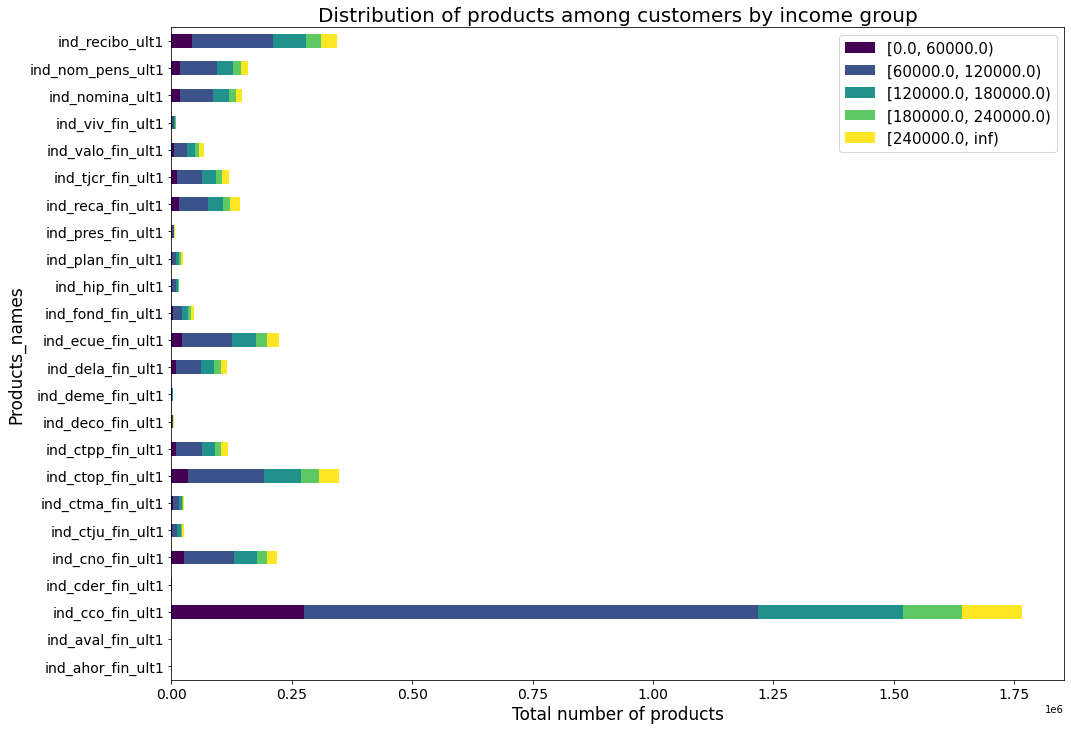

In [ ]:
# Plot of product share for each income group
df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='viridis')
plt.title('Distribution of products among customers by income group', fontsize=20, color='black') 
plt.xlabel('Total number of products', fontsize=17, color='black') 
plt.ylabel('Products_names', fontsize=17, color='black') 
plt.legend(prop={'size':15}, loc=1) 

"ind_cco_fin_ult1", i.e., the current account, is the dominant product. Now let's exclude it to further investigate the other products.

In [ ]:
# exclude the dominant product "ind_cco_fin_ult1"
exclude = ['ind_cco_fin_ult1']
df_a = df_a.T
df_a = df_a.drop(exclude, axis=1).T

In [ ]:
df_a.head()

renta,"[0.0, 60000.0)","[60000.0, 120000.0)","[120000.0, 180000.0)","[180000.0, 240000.0)","[240000.0, inf)"
ind_ahor_fin_ult1,0.0,73.0,59.0,51.0,51.0
ind_aval_fin_ult1,0.0,34.0,32.0,15.0,13.0
ind_cder_fin_ult1,152.0,559.0,270.0,119.0,103.0
ind_cno_fin_ult1,26325.0,104341.0,46571.0,20528.0,21563.0
ind_ctju_fin_ult1,1882.0,10644.0,6552.0,3424.0,3005.0


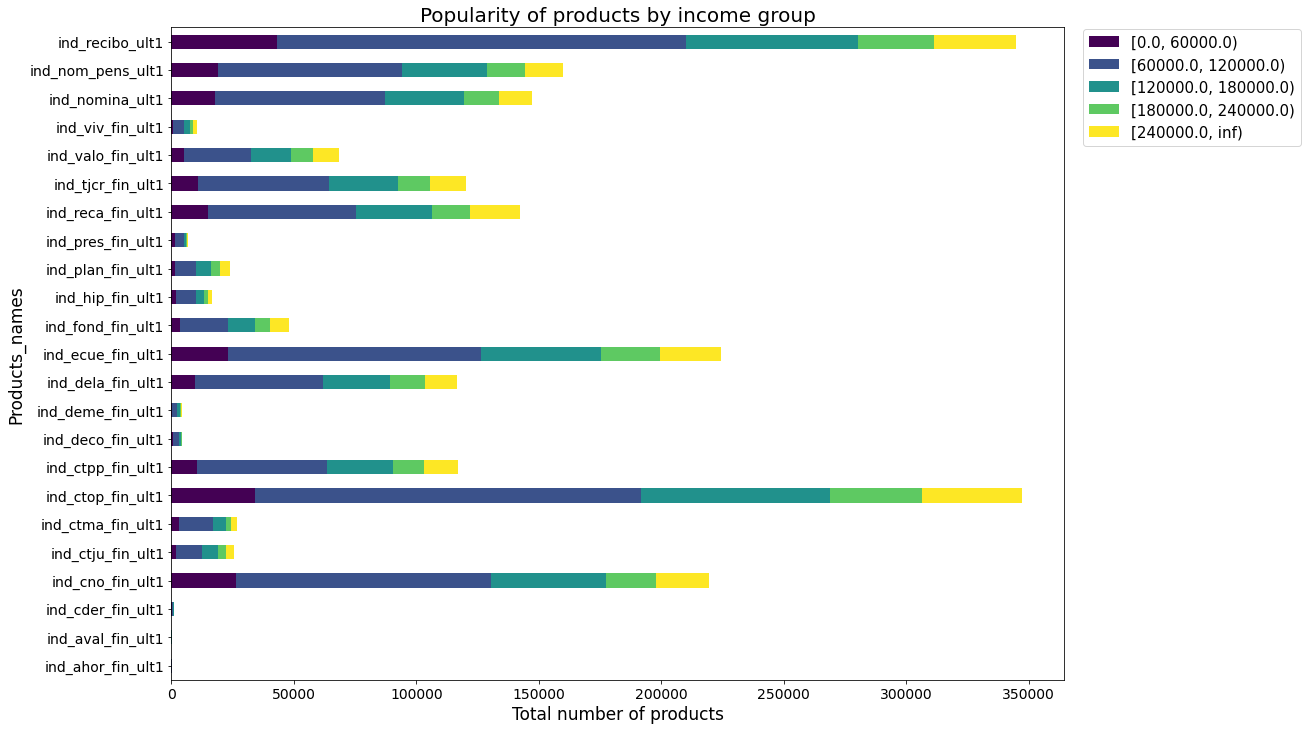

In [ ]:
# Plot of product share for each income group; excluding the dominant product 
df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='viridis')
plt.title('Popularity of products by income group', fontsize=20, color='black') 
plt.xlabel('Total number of products', fontsize=17, color='black') 
plt.ylabel('Products_names', fontsize=17, color='black') 
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.1, prop={'size':15}) 

The data situation seems to be quite consistent: within our product usage, people with an income of €60k-120k are most strongly represented. This is followed by the group with an income between €120k-180k. Unlike the age distribution, the income distribution within the products is relatively consistent. Except for "Current Accounts" there are more people with incomes with up to €60k than for other products. But that fits with the indication that especially younger people and students use this product, and this group normally tends to have a low income. 

##### Let's check number of products by channels
**To gain further insights for customer acquisition, customer acquisition broken down by different channels is an important metric. The goal is to better understand whether certain channels are more suitable than others in attracting customers for a particular product. This will help us tremendously in optimizing our recommendation algorithm.**

In [ ]:
df["canal_entrada"].value_counts().head(10)

KHE    812780
KAT    643799
KFC    618094
KHQ    119633
KFA     80906
KHK     47358
KHM     36201
KHN     23186
KHD     22709
KAS     17403
Name: canal_entrada, dtype: int64

Most of the customers joined through three major channels.

Since 6 out of 160 channels account for about 87.11% of the total number of customers attraction and to be able to visualze, we are going to exclude any channel has a contribution less than 1%.

In [ ]:
# Let's extract the necessary columns for this step
df_a = df.loc[:, ['canal_entrada']].join(df.loc[:, 'ind_ahor_fin_ult1':'ind_recibo_ult1'])

In [ ]:
# Let's subset the data to keep only the records from the five major channels
subset = ["KHE", "KAT", "KFC", "KFA", "KHK"]
df_a = df_a.loc[df_a['canal_entrada'].isin(subset)]

In [ ]:
df_a = df_a.groupby("canal_entrada").agg("sum")
df_a = df_a.T

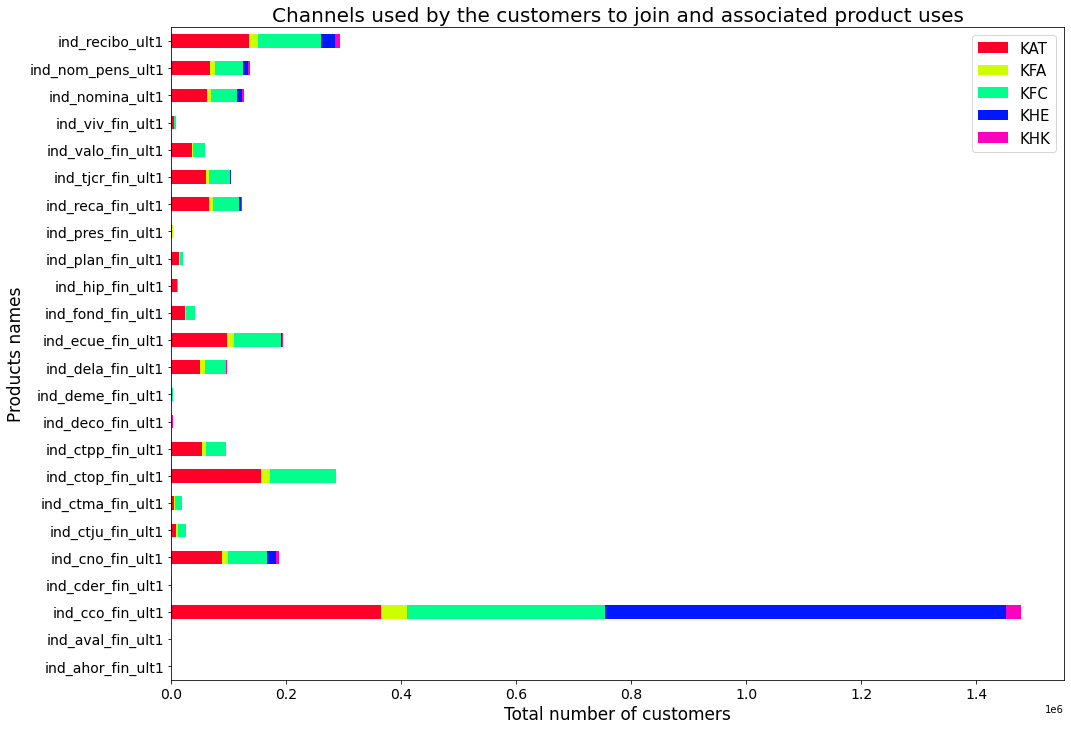

In [ ]:
# Channels used by the customer to join and the purchased products
df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='gist_rainbow')
plt.title('Channels used by the customers to join and associated product uses', fontsize=20, color='black') 
plt.xlabel('Total number of customers', fontsize=17, color='black') 
plt.ylabel('Products names', fontsize=17, color='black') 
plt.legend(prop={'size':15}) 

Again we will exclude the dominant product

In [ ]:
# exclude the dominant product "ind_cco_fin_ult1"
exclude = ['ind_cco_fin_ult1']
df_a = df_a.T
df_a = df_a.drop(exclude, axis=1).T

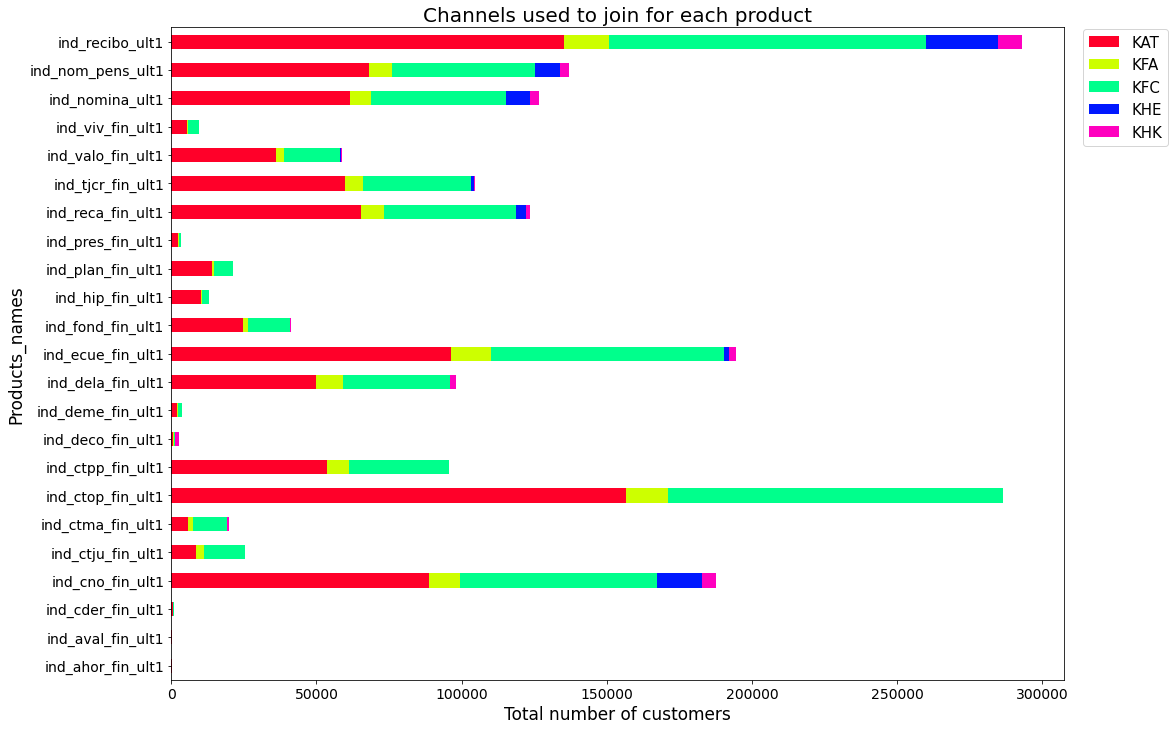

In [ ]:
# Channels share distribution of each product, excluding the dominant product
df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='gist_rainbow')
plt.title('Channels used to join for each product', fontsize=20, color='black') 
plt.xlabel('Total number of customers', fontsize=17, color='black') 
plt.ylabel('Products_names', fontsize=17, color='black') 
plt.legend(["KAT", "KFA", "KFC", "KHE", "KHK"], prop={'size':15}, loc=1) 
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.1, prop={'size':15}) 

That is a significant difference! Current accounts come dominantly via the channel "KHE", whereas this is hardly relevant for all other products. For products such as Particular Accounts, the "KAT" and "KFC" channels are particularly relevant. Based on these findings, we can understand our customer approach much better. 

##### Number of products by seniority group
**To wrap things up: As we want to optimize our product recommendations to existing customers, we have to look at the seniority distribution (i.e., how long they have been customers) of the usage of our products.  Are any difference between the products noticable? If so, it would be higly interesting for us to see which products are used at which stage of a customer lifetime.**

In [ ]:
# Let's extract the necessary columns for this step
df_a = df.loc[:, ['antiguedad']].join(df.loc[:, 'ind_ahor_fin_ult1':'ind_recibo_ult1'])

In [ ]:
# Let's create seniority groups
df_a = (df_a.groupby(pd.cut(df_a['antiguedad'], [0,50,100,150,200, pd.np.inf], right=False))
                     .sum())

In [ ]:
df_a.head()

,antiguedad,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
antiguedad,,,,,,,,,,,,,,,,,,,,,
"[0.0, 50.0)",31892400.0,0,0,993299,36,72855,7508,7551,21,50,...,95,1044,72,21918,15977,5202,27,45005.0,47497.0,121841
"[50.0, 100.0)",27640914.0,0,34,228374,166,28202,4035,18123,6453,52071,...,218,1431,1547,20588,17265,7671,519,18315.0,19975.0,44511
"[100.0, 150.0)",51285121.0,51,0,239420,450,38715,10566,410,111960,22643,...,5298,4196,3443,35477,26973,13840,3065,27153.0,29364.0,60471
"[150.0, 200.0)",72068662.0,115,43,229554,409,52889,3398,302,194710,28525,...,7038,9881,1142,42006,39794,25208,4608,38098.0,41778.0,78938
"[200.0, inf)",30366875.0,68,17,74958,142,26667,0,229,33960,13564,...,3877,7399,549,22341,20320,16529,2394,18831.0,21435.0,39081


In [ ]:
exclude = ["antiguedad"]
df_a = df_a.drop(exclude, axis=1).T

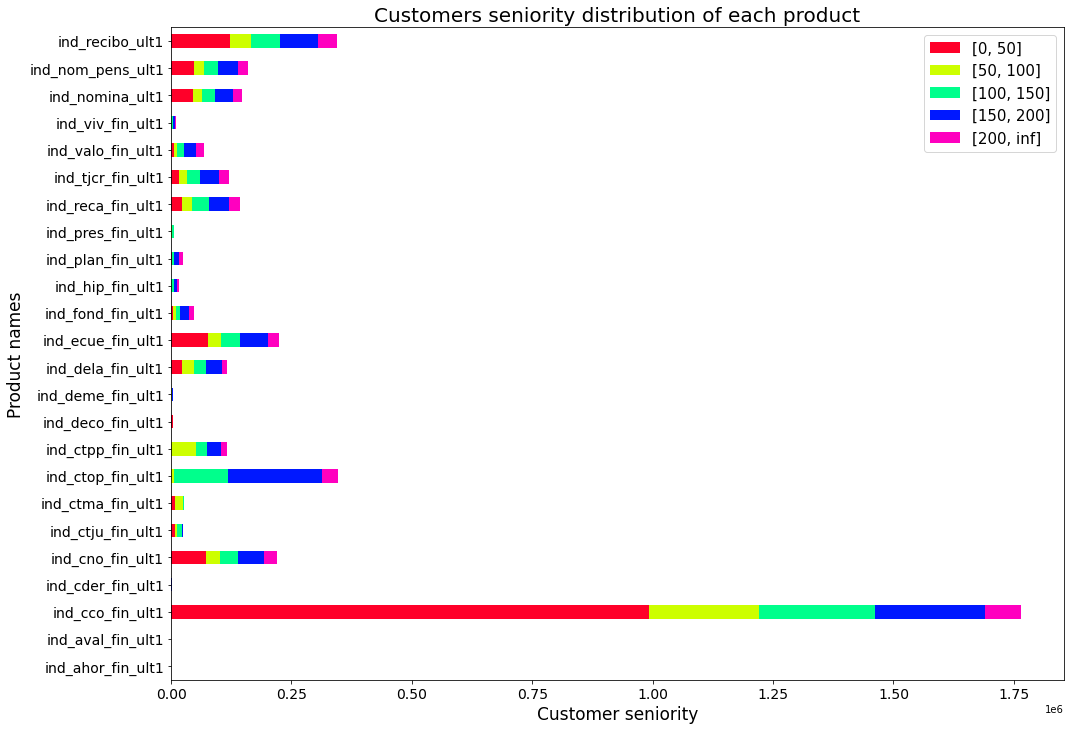

In [ ]:
# Customers' seniority distribution of each product
df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='gist_rainbow')
plt.title('Customers seniority distribution of each product', fontsize=20, color='black') 
plt.xlabel('Customer seniority', fontsize=17, color='black') 
plt.ylabel('Product names', fontsize=17, color='black') 
plt.legend([[0, 50], [50, 100], [100, 150], [150, 200], [200, inf]], prop={'size':15}) 

It is noticable that the dominant product is purchased most by those who joined less than 50 months ago.

Again we will exclude the dominant product

In [ ]:
# exclude the dominant product "ind_cco_fin_ult1"
exclude = ['ind_cco_fin_ult1']
df_a = df_a.T
df_a = df_a.drop(exclude, axis=1).T

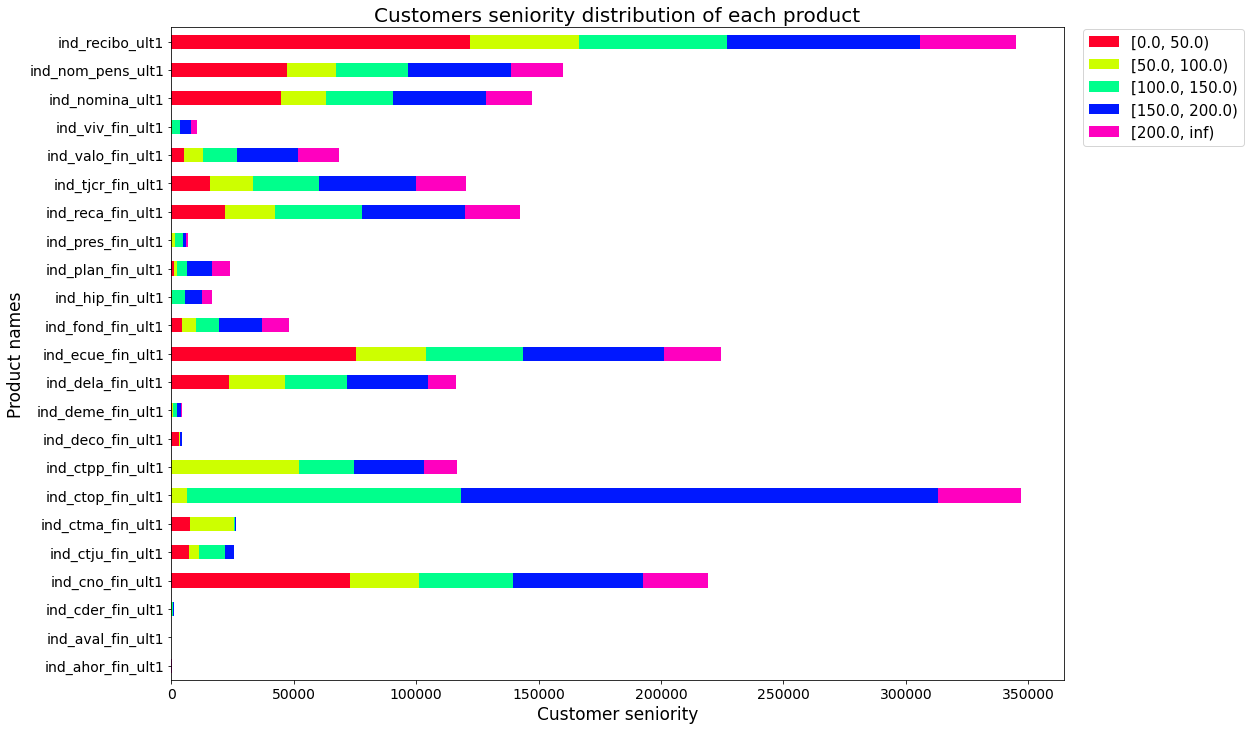

In [ ]:
# Customers' seniority distribution of each product
df_a.plot(kind='barh', stacked=True, fontsize=14, figsize=[16,12], colormap='gist_rainbow')
plt.title('Customers seniority distribution of each product', fontsize=20, color='black') 
plt.xlabel('Customer seniority', fontsize=17, color='black') 
plt.ylabel('Product names', fontsize=17, color='black') 
plt.legend([[0, 50], [50, 100], [100, 150], [150, 200], [200, inf]], prop={'size':15}) 
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.1, prop={'size':15}) 

The results obtained from this analysis are highly interesting. Current Accounts are dominantly acquired/used by customers who became our customers less than 50 months ago. For some other products (e.g. Particular Accounts) very senior customers (between 150-200 months) are dominant. 
From this, we can conclude that our Current Accounts seem to be an important product when approaching new customers. 

##### And that's a wrap! Let's now summarize what we have found during the data exploration/visualization: 

- Age: We have a bimodal distribution at age. We have many university-age customers and many middle-aged customers. However, the middle-aged customers own significantly more products than the supposedly younger ones. It is also interesting to note that the "Current Accounts" product is primarily used by younger customers, whereas all the other products are mainly used by people aged between 40 and 60. 
- Activity: Except for "Current Accounts", where we have many inactive customers, most of our customers use their products actively/regulary.
- Gender: The breakdown by gender is fairly evenly weighted. Likewise for the distribution within the use of products. 
- Income: Distribution of income among the products is also fairly evenly weighted. Most people have a income between €60k-120k. 
- Channels: Most people using current accounts joined via the "KHE" channel. For the remaining products, the channels "KAT" and "KFC" are the most important customer acquisiton channels. 
- Seniority: The seniority of customers using "Current Accounts" is lower than for the remaning products. 
- Products: The most used product is "Current Accounts". However, this product category implies an exceptionally high number of inactive accounts. The second and third most used products are "Particular Accounts" and "Direct Debit".


Let's now head over to the feature engineering and then build up our models. 

# 4. Feature Engineering



In [ ]:
#working with a copy of df
dfb = df.copy()

In order to better identify changes in the product portfolio per customer, we are adding a feature to show in which month the observation is in (i.e. the dataset starts in January 2015 so that is month 0 and February 2015 is month 1)

In [ ]:
months = list(set(dfb["fecha_dato"]))
months.sort()

def date_to_month(date):
  month = months.index(date)
  return month

dfb["Month"] = dfb["fecha_dato"].apply(date_to_month)
dfb["next_Month"] = dfb["Month"] + 1

Now we merge the data dataframe with itself to add the observation and product portfolio of the next month to the current oberservation to find out whether a product has been added or dropped in the next month.

## Features

### Existing Features
To make our various categorical usable in the choosen model, we have to encode two-dimensional categories into binary variables and one-hot-endcode multi-dimensional categories due to their nominal nature for both dataframes (jan2015 - may2016, june2016)

The following variables will be ignored in the model:
1. fecha_dato: Instead of the actual date we focus on the month of the record, the feature created in the step before.
2. ind_empleado: Due to a extremly low variance in values,we decided to focus on records with predominant value (i.e. "N")
3. pais_residencia: Since we only focus on Spanish customers (as found out in the data cleaning), the variable is redundant
4. fecha_alta: Instead of the actual date we will use the seniority in months
5. indresi: Since the majority of clients' residence country is the same as the bank's country ('S'), we focus on S only and the variable is redundant
6. We drop product columns ind_aval_fin_ult1 and ind_ahor_fin_ult1 because, as seen above in the data exploration and visualization section "# of products by actiity and sex", no customer adopted these 2 products.

In [ ]:
#dropping the features
dfb.drop(["fecha_dato", "ind_empleado", "pais_residencia", 'fecha_alta','indresi','ind_aval_fin_ult1','ind_ahor_fin_ult1' ], axis = 1, inplace = True)

#changing datatypes to categorical variables
dfb["ind_nuevo"] = dfb[ "ind_nuevo"].astype('int')  

to_be_coded = ["sexo", "tiprel_1mes", "indext", "canal_entrada", "indfall", "nomprov", "segmento"]
for i in to_be_coded:
    dfb[i] = dfb[i].astype('category') 
    dfb[i] = dfb[i].cat.codes

In [ ]:
#dropping the features for june as well
df_june.drop(["fecha_dato", "ind_empleado", "pais_residencia", 'fecha_alta','indresi'], axis = 1, inplace = True)

#changing datatypes to categorical variables
df_june["ind_nuevo"] = df_june[ "ind_nuevo"].astype('int')  

to_be_coded = ["sexo", "tiprel_1mes", "indext", "canal_entrada", "indfall", "nomprov", "segmento"]
for i in to_be_coded:
    df_june[i] = df_june[i].astype('category') 
    df_june[i] = df_june[i].cat.codes

In [ ]:
#creating list of the column names for each product
labels = dfb.columns
products = list(filter(lambda k: 'ult' in k, labels))

In [ ]:
len(products)

22

### New Features

Our current Dataset includes demographic information about each customer and their active products. The goal of our model is to find out which product a customer is most likely to purchase. Thus it would be beneficial to also focus on the change of products for each customer and month. For this we create extra lag features for each product and each month, describing:


**1. How long a product was active in the previous months? (product_cumsum)**: <br> 
The feature sums up the months the product was active before the month of the record normalized by the number of Months until the record.
The rationale behind this feature is that if the product was active for a longer time, it must have been useful for the customer. Neglecting the potential reason for discontinuing the product, this could hint at a higher probability of being picked up again.<br>
**2. How the product ownership changed in comparison to the previous month (product_change)**: <br>
The feature indicates whether the product was dropped (-1) or added (1) or if nothing happened with it (0) by a customer in comparison to the previous month. Here one could assume that if a product was dropped only a month ago, that the probaility that it is picked up again could be lower than otherwise.<br>
**3. How many transactions (added and dropped) existed regarding the product (product_transaction)**:<br>
The feature sums up all transactions for each product until the month of the record. If a product has been added and dropped multiple times, it might be more probable to be added again.

#### How long was a product active in the previous months

In [ ]:
#The overarching goal is to create column for each product that sums up for each month how long it was activ in the previous seperatly for each customer

##First we create copy of our df droppping all unneccary features for this operation
dfc = dfb.copy()
df_products_only = pd.concat([dfc [["ncodpers", "Month"]], dfc.filter(regex = "ult" )], axis=1)
df_products_only.sort_values(by = "Month", inplace = True)


##Now we  create a groupby DF for each month to sum up the active months and append the results with each other
df_product_sum = pd.DataFrame()
for i in set(df_products_only["Month"]):
    zz = df_products_only[df_products_only["ncodpers"].isin(df_products_only[df_products_only["Month"] == i]["ncodpers"])]
    z = zz[zz["Month"] < i+1].drop("Month", axis = 1).groupby(by = ["ncodpers"]).sum().reset_index()    
    z["Month"] = i
    df_product_sum = pd.concat([df_product_sum, z])

##Then we normalize the columns by dividing it by the number of months 
for i in products:
  df_product_sum[i] = df_product_sum[i]/df_product_sum["Month"]

## Since we are dividing by O for recored in the first month we must replace the NaN with 0
df_product_sum.fillna(0, inplace = True)
df_product_sum.replace([np.inf, -np.inf], 0, inplace=True)

#Now we expand our innital featureDf by merging it with this one
df_features= dfb.merge(df_product_sum, on = ["ncodpers", "Month"], suffixes = ["", "_cumsum"])

#### How the product ownership changed in comparison to the previous month


In [ ]:
# Goal to create a column showing the change in ownership of a product by basically subtracting the status of one month with the status of the month before

## First we create two copy of our df droppping all unneccary features for this operation. However, one df will contain an extra column with the previous
## month used to as merge key to expand a record with records of the previous month 
dfd = dfb.copy()
df_products_only = pd.concat([dfd[["ncodpers", "Month"]], dfd.filter(regex = "ult" )], axis=1)
df_products_only2 = df_products_only.copy()
df_products_only["prev_Month"] = df_products_only["Month"] -1

## Merging both  dataframes with each other to create a df with information about the current and the previous month:
df_change = df_products_only.merge(df_products_only2, left_on = ["ncodpers", "prev_Month"], right_on = ["ncodpers", "Month"], suffixes = ["", "_previous"], how = "left") 

## Caculating the change of the product by subtracting the current product status with the product status
for i in products:
  current_prod = i 
  prev_prod = i + "_previous"
  change = i + "_change"
  df_change[change] = df_change[current_prod] - df_change[prev_prod]
  df_change[change].astype(int, errors = "ignore")

## Fill NaN with 0 as there are no changes in Month 0
df_change.fillna(0, inplace = True)
## Some models might have problem with negative values so lets add a 1 to all values 
df_change = df_change + 1

## Merging the change df with our feature df 
df_features2 = pd.concat([df_features, df_change.filter(regex = "change" )], axis=1)

#### How many transactions existed regarding the product 

In [ ]:
# Goal to create a column showing how many times a product was added or dropped until the time of the record

## For this we use the df_change from above as the base.
##First we change the value of the change_columns from the type of change to if a transaction (i.e. drop or add occured)
def change_to_transaction(x):
    if x != 0:
        y = 1
    else:
        y = 0
    return y

df_transaction = pd.DataFrame()

for i in df_change.filter(regex = "change" ).columns.values:
    j = i[:-7] + "_transaction"
    df_transaction[j] = df_change.filter(regex = "change" )[i].apply(change_to_transaction)
    

df_transaction = pd.concat([df_features2[["ncodpers", "Month"]], df_transaction], axis=1)

##Now we  create a several DFs for each month to sum up the number of transaction until the respective month and append the results with each other
df_transaction_sum = pd.DataFrame()
for i in set(df_transaction["Month"]):
    z = df_transaction[df_transaction["Month"] < i+1].drop("Month", axis = 1).groupby(by = ["ncodpers"]).sum().reset_index()    
    #print(len(z))
    z["Month"] = i
    df_transaction_sum = pd.concat([df_transaction_sum, z])
    #print(i)
    
##Lastly, we merge it with our latest feature DF
df_features3 = df_features2.merge(df_transaction_sum, on = ["ncodpers", "Month"], suffixes = ["", "_cumsum"])

In [ ]:
len(df_features3)

2678211

### Target Variables
Our target variables indicates whether or not a product will be added or not

In [ ]:
df_two_months = dfb.merge(dfb, left_on = ["ncodpers", "next_Month"], right_on = ["ncodpers", "Month"], suffixes = ["_actual", "_next"])
y_status =df_two_months.filter(regex='ult1_actual')

In [ ]:
#The goal is to create a df with the infromtion if will be added in the next month

##First we merge our original DF with itself to add the product information of the next month to each record

df_two_months = dfb.merge(dfb, left_on = ["ncodpers", "next_Month"], right_on = ["ncodpers", "Month"], suffixes = ["_actual", "next"])

## Caculating the change of the product by subtracting the next months product status with the product status of the current month 
for i in products:
  next_prod = i + "next"
  actual_prod = i + "_actual"
  change = i + "_change"
  df_two_months[change] = df_two_months[next_prod] - df_two_months[actual_prod]
  df_two_months[change].astype(int, errors = "ignore")

## Now we delete all columns except the ones with the change
df_change2 = df_two_months.filter(regex='change')

##Then we change the the values of the change columns from the type of change to if the the product has been added or not 
def activate (x):
  if x == 1:
    y = 1
  else:
    y = 0
  return y

iterCol = df_change2.columns.values

for i in iterCol:
  colName = i[:-7]+"_activated"
  df_change2[colName] = df_change2[i].apply(activate)


y_activated = df_change2.filter(regex='_activated')
##interestingly the df is smaller as expected; this if because the last entry for a customer are not included
##that means that we also exclude them from our feature df

### X and Y

In [ ]:
## First we remove the features from the last month mai, since we will use them to predict our recommendations from june
df_features_june_prediction = df_features3[df_features["Month"] == df_features3["Month"].max()]
df_features_training = df_features3[df_features3["Month"] < df_features3["Month"].max()]

#lets remove the remaining rows for which do not have the target variables :
df_features_training = df_features_training[df_features_training["index"].isin(df_two_months["index_actual"])]


##now then drop the identifier so we only have the features
X_june = df_features_june_prediction.drop(["index", "Month","next_Month"], axis = 1)
X = df_features_training.drop(["index","ncodpers", "Month","next_Month"], axis = 1)

We also have to merge the information of the products from the month May 2016 with the dataframe of june 2016, in order to predict the product to recommend for the June 2016.

In [ ]:
#X_june basically contains the information from May. This is also supposed to, but only for the prodcut infromation and not the demographics. 
#For the Demographics we use the availaibe information from June 2016 (i.e df_june)
#Hence, we must drop them from X_june and merge the reduced X_june with df_june
to_drop = ['sexo', 'age', 'ind_nuevo', 'antiguedad', 'indrel',
       'indrel_1mes', 'tiprel_1mes', 'indext', 'canal_entrada', 'indfall',
       'tipodom', 'cod_prov', 'nomprov', 'ind_actividad_cliente', 'renta',
       'segmento']

X_june.drop(to_drop, inplace = True, axis = 1)

X_june = df_june.merge(X_june, on = "ncodpers", how = "inner")
index = X_june.ncodpers
X_june.drop(["ncodpers", "index"], inplace = True, axis = 1)


In [ ]:
df_june

,index,ncodpers,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indext,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento
124021,1255,1171970,1,22,0,33,1,1.0,0,0,134,0,1,28.0,30,0,153753.90,2
124022,517183,283898,0,49,0,175,1,1.0,1,0,111,0,1,28.0,30,0,259585.98,1
124023,517184,283901,1,71,0,176,1,1.0,0,0,111,0,1,28.0,30,1,160977.96,1
124024,1254,1171969,0,27,0,33,1,1.0,1,0,134,0,1,28.0,30,0,131453.64,2
124025,517198,283879,1,41,0,176,1,1.0,0,0,111,0,1,28.0,30,1,178154.34,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62012,568364,419882,0,62,0,172,1,1.0,0,0,110,0,1,19.0,23,1,265637.58,1
62013,196400,1112969,0,54,0,42,1,1.0,0,0,22,0,1,19.0,23,1,106291.41,1
62016,104705,1218230,0,23,0,31,1,1.0,1,0,134,0,1,19.0,23,0,65520.00,2
62018,104666,1218252,1,22,0,31,1,1.0,1,0,134,0,1,19.0,23,0,120913.11,2


We are only interested in entries with transactions (i.e. a product is added) in a certain month, since:
1. A transaction is a relativly rare event. Hence a lot of the data is sparse with regards to transactions <br>  
2. The behaviour of customer might be dependent on time of the year with seasonal trends. Hence, it might be smart to train a model for a certain month only with data from that month from previous years




In [ ]:
#building the function to only filter out the dataframe with transactions
def specify_df(transaction_only = True, month = ""):
  if transaction_only == True:
    sum = y_activated.sum(axis=1)
    if month != "":
      y_only_transaction = y_activated[(sum > 0) & (dfb["Month"] == month)]
      x_only_transaction = X[(sum > 0) & (dfb["Month"] == month)]
    else:
      y_only_transaction = y_activated[(sum > 0)]
      X1 = X.reset_index(drop = True)
      x_only_transaction = X1[(sum > 0)]
  else:
    y_only_transaction = y_activated[dfb["Month"] == month]
    x_only_transaction = X[dfb["Month"] == month]

  return x_only_transaction, y_only_transaction

#applying it
x1,y1 = specify_df(True)

# 5. Model 

##### Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x1, y1, random_state=42)

## Model 1 - MultinomialNB with BinaryRelevance

As we are interested to see which products are likely to be bought by customers, we use a multi-label classifier as this allows us to work with more than one target variable. In other words, in a multilabel classification we end up with multiple labels that are the outputs for a given prediction thus a  given input possibly belongs to more than one label.
In order to make predictions  we need to transform the multi-label dataset into a single-label dataset because single-label datasets and problems are machine-readable and make it easier to build a model. We chose to use the Binary Relevance technique which splits the multi-label problems into unique single-class problems. More clearly this transforms a multi-label classification problem with N labels into N single-label separate binary classification problems using the same base classifier.The output of the prediciton is the union of all single label classifiers. Furthermore, we chose the MultinomialNB() which is the Naive Bayes algorithm method used for classification, and we need an algorithm that is capable to handle a multi-class problem.




##### Model 1.1: default settings

In [ ]:
#TO INSTALL SCIKIT-MULTILEARN
#UN-COMMENT IN CASE IT'S NOT INSTALLED ON YOUR MACHINE
!pip install scikit-multilearn

In [ ]:
#BINARY RELEVANCE 
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB

#Transforms a multi-label classification problem with L labels into L single-label separate binary classification problems 
#using the same base classifier provided in the constructor 
#The prediction output is the union of all per label classifiers

#convert the multilabel to a multiclass problem, using multinomialNB as algorithm method for the classification
bin_rel_classifier = BinaryRelevance(MultinomialNB())

#the classifier can not handle negative values, hence we must change instances of the _change features 
#where a products has been dropped from the value -1 to 0, 
#so limitng us from three dimensions (dropped, unchanged, added) to two dimensions (unchanged or dropped, added)


#fit the model
bin_rel_classifier.fit(X_train,y_train)
#make prediction on test set
y_pred = bin_rel_classifier.predict(X_test)

y_pred = y_pred.toarray()
y_pred = pd.DataFrame(y_pred)


In [ ]:
#evaluate the model with accuracy and precision score for the test set
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

#lets create a df to see how well the model performs for each class = product 
scores = pd.DataFrame(columns = ['Product','Accuracy','Precision'])
scores["Product"] = products

for i in range(22):
  scores["Precision"][i] = precision_score(y_test.iloc[:,i],y_pred.iloc[:,i])

for i in range(22):
  scores["Accuracy"][i] = accuracy_score(y_test.iloc[:,i],y_pred.iloc[:,i])

#scores

In [ ]:
#as info for the business analysts
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names = products))

                   precision    recall  f1-score   support

 ind_cco_fin_ult1       0.19      0.58      0.29      2734
ind_cder_fin_ult1       0.00      0.80      0.00         5
 ind_cno_fin_ult1       0.12      0.63      0.21      1750
ind_ctju_fin_ult1       0.00      0.79      0.01        19
ind_ctma_fin_ult1       0.02      0.71      0.03       153
ind_ctop_fin_ult1       0.02      0.78      0.04       194
ind_ctpp_fin_ult1       0.01      0.61      0.02       137
ind_deco_fin_ult1       0.02      0.94      0.04        83
ind_deme_fin_ult1       0.00      0.46      0.00        13
ind_dela_fin_ult1       0.04      0.51      0.08       606
ind_ecue_fin_ult1       0.09      0.60      0.16      1308
ind_fond_fin_ult1       0.01      0.46      0.03       183
 ind_hip_fin_ult1       0.00      0.60      0.00         5
ind_plan_fin_ult1       0.00      0.50      0.01        26
ind_pres_fin_ult1       0.00      0.60      0.00         5
ind_reca_fin_ult1       0.02      0.38      0.05       

In [ ]:
print("Overall test-accuracy across all products: ", scores.Accuracy.mean().round(3))
print("Overall test-precision across all products: ", scores.Precision.mean().round(3))

Overall test-accuracy across all products:  0.688
Overall test-precision across all products:  0.087


In [ ]:
#accuracy top 3
display(scores.sort_values(by = "Accuracy", ascending= False).head(3))
display("means top 3 accuracy",scores.sort_values(by = "Accuracy", ascending= False).head(3).mean())

,Product,Accuracy,Precision
3,ind_ctju_fin_ult1,0.841949,0.004532
7,ind_deco_fin_ult1,0.838739,0.022681
18,ind_viv_fin_ult1,0.78465,0.000223


'means top 3 accuracy'

Accuracy     0.821779
Precision    0.009145
dtype: float64

In [ ]:
#precision top 3
display(scores.sort_values(by = "Precision", ascending= False).head(3))
display("means top 3 precision",scores.sort_values(by = "Precision", ascending= False).head(3).mean())

,Product,Accuracy,Precision
21,ind_recibo_ult1,0.599722,0.447735
20,ind_nom_pens_ult1,0.73104,0.383081
16,ind_tjcr_fin_ult1,0.653667,0.263557


'means top 3 precision'

Accuracy     0.661477
Precision    0.364791
dtype: float64

##### Evaluation Metric + next steps

Here we have run the model just with the default values to get an idea of how well it performs. We can see that the accuracy (0.69) of predicting each product is overall much higher than the precision (0.09), which is extremely low. However, this is not what we are looking for. Our evaluation metric will namely be precision because we want to reward the solution where the person actually adds one of the items we recommend. As it is not our goal to predict if someone will indeed buy something or not, we want to recommend the products with the highest likelihood to be bought (because a purchase is relatively rare the probabilities are very small). So as the **precision** for all products is quite low (**ranging only from 0-0.45**) and the mean precision of the **top 3** is also low **0.36479**, we will try to hypertune our parameters and find a better model. 

##### Hypertuning: finding the best model

Here we are using gridsearchCV and RandomizedSearchCV for adapting our model parameters as we have not that many parameters (e.g. in comparision to a neural network). Further, while taking a bit longer than RandomizedSearchCV, best_params_ can guarantee us that we get the best model resutls according to our scoring with the test values as it will test every single combination.

In [ ]:
from sklearn.model_selection import GridSearchCV
#perform hyperparameter tuning in order to improve the model, including cross-validation in order to reduce potential overfitting
parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.3,0.5,0.7,1.0], #modifies the smoothing of the model
    }
]
#scoring = {'Accuracy':'accuracy','Precision':'precision'}

classifier_gridsearch = GridSearchCV(BinaryRelevance(), parameters, scoring='precision_weighted',cv=10)# use weighted bc. considers how many of each class there were in its calculation
classifier_gridsearch.fit(X_train, y_train)

print (classifier_gridsearch.best_params_, classifier_gridsearch.best_score_)
best_a = classifier_gridsearch.best_params_["classifier__alpha"] 

{'classifier': MultinomialNB(alpha=0.3), 'classifier__alpha': 0.3} 0.2865328436962934


In [ ]:
#retrain the model with the best found hyperparameters
#convert the multilabel to a multiclass problem, using multinomialNB as algorithm method for the classification
bin_rel_classifier = BinaryRelevance(MultinomialNB(alpha=best_a))

#fit the model
bin_rel_classifier.fit(X_train,y_train)
#make prediction on test set
y_pred = bin_rel_classifier.predict(X_test)

y_pred = y_pred.toarray()
y_pred = pd.DataFrame(y_pred)

In [ ]:
#evaluate the optimized model with accuracy and precision score

#lets create a df to see how well the model performs for each class = product 
scores = pd.DataFrame(columns = ['Product','Accuracy','Precision'])
scores["Product"] = products

for i in range(22):
  scores["Precision"][i] = precision_score(y_test.iloc[:,i],y_pred.iloc[:,i])

for i in range(22):
  scores["Accuracy"][i] = accuracy_score(y_test.iloc[:,i],y_pred.iloc[:,i])

#scores

In [ ]:
print("Overall accuracy across all products: ", scores.Accuracy.mean().round(3))
print("Overall precision across all products: ", scores.Precision.mean().round(3))

Overall accuracy across all products:  0.691
Overall precision across all products:  0.088


In [ ]:
#accuracy top 3
display(scores.sort_values(by = "Accuracy", ascending= False).head(3))
display("means top 3 accuracy",scores.sort_values(by = "Accuracy", ascending= False).head(3).mean())

,Product,Accuracy,Precision
3,ind_ctju_fin_ult1,0.855411,0.004952
7,ind_deco_fin_ult1,0.840224,0.022887
18,ind_viv_fin_ult1,0.786327,0.000224


'means top 3 accuracy'

Accuracy     0.827321
Precision    0.009355
dtype: float64

In [ ]:
#precision top 3
display(scores.sort_values(by = "Precision", ascending= False).head(3))
display("means top 3 precision",scores.sort_values(by = "Precision", ascending= False).head(3).mean())

,Product,Accuracy,Precision
21,ind_recibo_ult1,0.605998,0.453561
20,ind_nom_pens_ult1,0.731328,0.383373
16,ind_tjcr_fin_ult1,0.655248,0.264626


'means top 3 precision'

Accuracy     0.664191
Precision    0.367187
dtype: float64

##### Findings Model 1


After tuning our model to increase the precision, it just went minimally up (from overall 0.087 to 0.088). Also at the **top 3** products with highest precision the values are still really low (on average just **0.3671** - only approx. 0.003 more) with almost no change in the accuracy, thus we will disregard this model and try another algorithm that hopefully performs much better in both precision and accuracy.

## Model 2 - XGBoost

As the first models performance did not satisfy our precision requirements we chose to try another approach. Our choice fell on XGBoost which is an implementation of gradient boosted decision trees especially designed for speed and performance, which seems to be appropriate for our problem. XGBoost is a random forest-like decision tree ensemble learning algorithm  for classification and regression. Ensemble learning algorithms combine multiple machine learning algorithms to get better models. As we are still trying to classify multiple labels we are using Scikit-learns MultioutputClassifier. This classifier fits one classifier for every target and helps especially for extending classifiers that do not natively support multi-target classification.





##### Model 2.1: default settings

In [ ]:
#https://dongr0510.medium.com/multi-label-classification-example-with-multioutputclassifier-and-xgboost-in-python-98c84c7d379f DELETE
#import libraries
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [ ]:
#classifying multi-label data with multioutputclassifier & xgboost with default parameters
xgboost_classifier = MultiOutputClassifier(estimator=XGBClassifier())
xgboost_classifier.fit(X_train, y_train)

MultiOutputClassifier(estimator=XGBClassifier())

In [ ]:
y_train_pred = xgboost_classifier.predict(X_train)
y_train_pred = pd.DataFrame(y_train_pred)

In [ ]:
y_pred = xgboost_classifier.predict(X_test)
y_pred = pd.DataFrame(y_pred)

In [ ]:
#compute accuracy+precision metrics on training set --> for data scientists 
#lets create a df to see how well the model performs for each class = product 
scores = pd.DataFrame(columns = ['Product','Accuracy','Precision'])
scores["Product"] = products

for i in range(22):
  scores["Precision"][i] = precision_score(y_train.iloc[:,i],y_train_pred.iloc[:,i])

for i in range(22):
  scores["Accuracy"][i] = accuracy_score(y_train.iloc[:,i],y_train_pred.iloc[:,i])

#scores

#overall
print("Overall train_accuracy across all products: ", scores.Accuracy.mean().round(3))
print("Overall train_precision across all products: ", scores.Precision.mean().round(3))

Overall train_accuracy across all products:  0.974
Overall train_precision across all products:  0.779


In [ ]:
#as info for data scientists only 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names = products))

                   precision    recall  f1-score   support

 ind_cco_fin_ult1       0.82      0.86      0.84      2734
ind_cder_fin_ult1       0.00      0.00      0.00         5
 ind_cno_fin_ult1       0.89      0.47      0.61      1750
ind_ctju_fin_ult1       0.95      1.00      0.97        19
ind_ctma_fin_ult1       0.78      0.05      0.09       153
ind_ctop_fin_ult1       0.71      0.38      0.50       194
ind_ctpp_fin_ult1       0.65      0.42      0.51       137
ind_deco_fin_ult1       0.54      0.25      0.34        83
ind_deme_fin_ult1       0.00      0.00      0.00        13
ind_dela_fin_ult1       0.57      0.08      0.14       606
ind_ecue_fin_ult1       0.89      0.46      0.61      1308
ind_fond_fin_ult1       0.60      0.02      0.03       183
 ind_hip_fin_ult1       0.00      0.00      0.00         5
ind_plan_fin_ult1       0.00      0.00      0.00        26
ind_pres_fin_ult1       0.00      0.00      0.00         5
ind_reca_fin_ult1       0.69      0.09      0.16       

In [ ]:
#compute accuracy+precision metrics on TEST 
#lets create a df to see how well the model performs for each class = product 
scores = pd.DataFrame(columns = ['Product','Accuracy','Precision'])
scores["Product"] = products

for i in range(22):
  scores["Precision"][i] = precision_score(y_test.iloc[:,i],y_pred.iloc[:,i])

for i in range(22):
  scores["Accuracy"][i] = accuracy_score(y_test.iloc[:,i],y_pred.iloc[:,i])

#scores

#overall
print("Overall test_accuracy across all products: ", scores.Accuracy.mean().round(3))
print("Overall test_precision across all products: ", scores.Precision.mean().round(3))

Overall test_accuracy across all products:  0.974
Overall test_precision across all products:  0.553


In [ ]:
#accuracy top 3
display(scores.sort_values(by = "Accuracy", ascending= False).head(3))
display("means top 3 accuracy",scores.sort_values(by = "Accuracy", ascending= False).head(3).mean())

,Product,Accuracy,Precision
3,ind_ctju_fin_ult1,0.999952,0.95
18,ind_viv_fin_ult1,0.99976,0.0
12,ind_hip_fin_ult1,0.99976,0.0


'means top 3 accuracy'

Accuracy     0.999824
Precision    0.316667
dtype: float64

In [ ]:
#precision top 3
display(scores.sort_values(by = "Precision", ascending= False).head(3))
display("means top 3 precision",scores.sort_values(by = "Precision", ascending= False).head(3).mean())

,Product,Accuracy,Precision
3,ind_ctju_fin_ult1,0.999952,0.95
20,ind_nom_pens_ult1,0.915345,0.898594
10,ind_ecue_fin_ult1,0.962775,0.892171


'means top 3 precision'

Accuracy     0.959357
Precision    0.913589
dtype: float64

It is clear that the XGBoost already performs much better than the first model, also just with default settings. Overall accuracy and precision went up(0.97 and 0.55 respectively), but what is most astonishing and important for us is that the **precision at the top-3** is significantly higher with **0.91359**. There we also have a pretty high accuracy with approx0.96 so that we could already say that this would be a useful model for us in order to recommend the top 3 products to a customer, which they might acutally adapt in the next month. However, let´s first see if we can get even better results through hypertuning. 



##### Hyptertuning: finding the best model

As GridSearch goes through all the parameters but has with the xgBoost an immensily long run-time, we decided to try RandomizedSearchCV instead for hypertuning this model.  (Please note that we have run this in a copy of this  notebook and found the printed values because of the long run-time)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
## to avoid problems with the runtime we reduce our df even further
#x1_reduced = x1[x1.index % 2 == 0]
#y1_reduced = y1[y1.index % 2 == 0]

In [ ]:
#parameters = {
#            'estimator__learning_rate': [0.1, 0.2, 0.3,0.4], #modifies the speed of learning
#            'estimator__max_depth': [6,9,12,15] #modifies the depth of the tree
#                 }
    
#xgboost_classifier = MultiOutputClassifier(estimator=XGBClassifier())
#randm = RandomizedSearchCV(estimator=xgboost_classifier, param_distributions = parameters, 
                               #cv = 3, n_iter = 20, n_jobs=-1, scoring = "precision_weighted")
    
#randm.fit(x1_reduced, y1_reduced)

#best_learning_rate = randm.best_params_["estimator__learning_rate"] 
#best_max_depth = randm.best_params_["estimator__max_depth"] 

In [ ]:
best_learning_rate = "best_learning_rate: 0.1"
best_max_depth = "best_max_depth:  6"
best_score = "best_score: 0.7894471463678427"

print(best_learning_rate)
print(best_max_depth)
print(best_score)

best_learning_rate: 0.1
best_max_depth:  6
best_score: 0.7894471463678427


Our score with the best parameters from our Randomized Gridsearch **performed much worse** than the default parameters and also took crazy long (2+h). Hence we decided to take it out and continue with the default parameters.

##### Findings Model 2

**After hyptertuning** we can see that our model has **not improved** but actually got worse. Thus, using a randomized search or adapting the hyperparameters even more might be an option. However, the xgBoost model with default parameters already performs significantly well and we will proceed with this. As a recap: the top 3 precision products had an avg. **accuracy of 0.96 and a precision of 0.91**, meaning that there the model does a **great job at recommending products the customer will like to add** in the next month.

### Feature importance

Let`s have a look what is important for us for recommending products that will be purchased by our costumers. To this we average the respective importance of each feature over all predicter from our Gradient Boosting Algorithm.

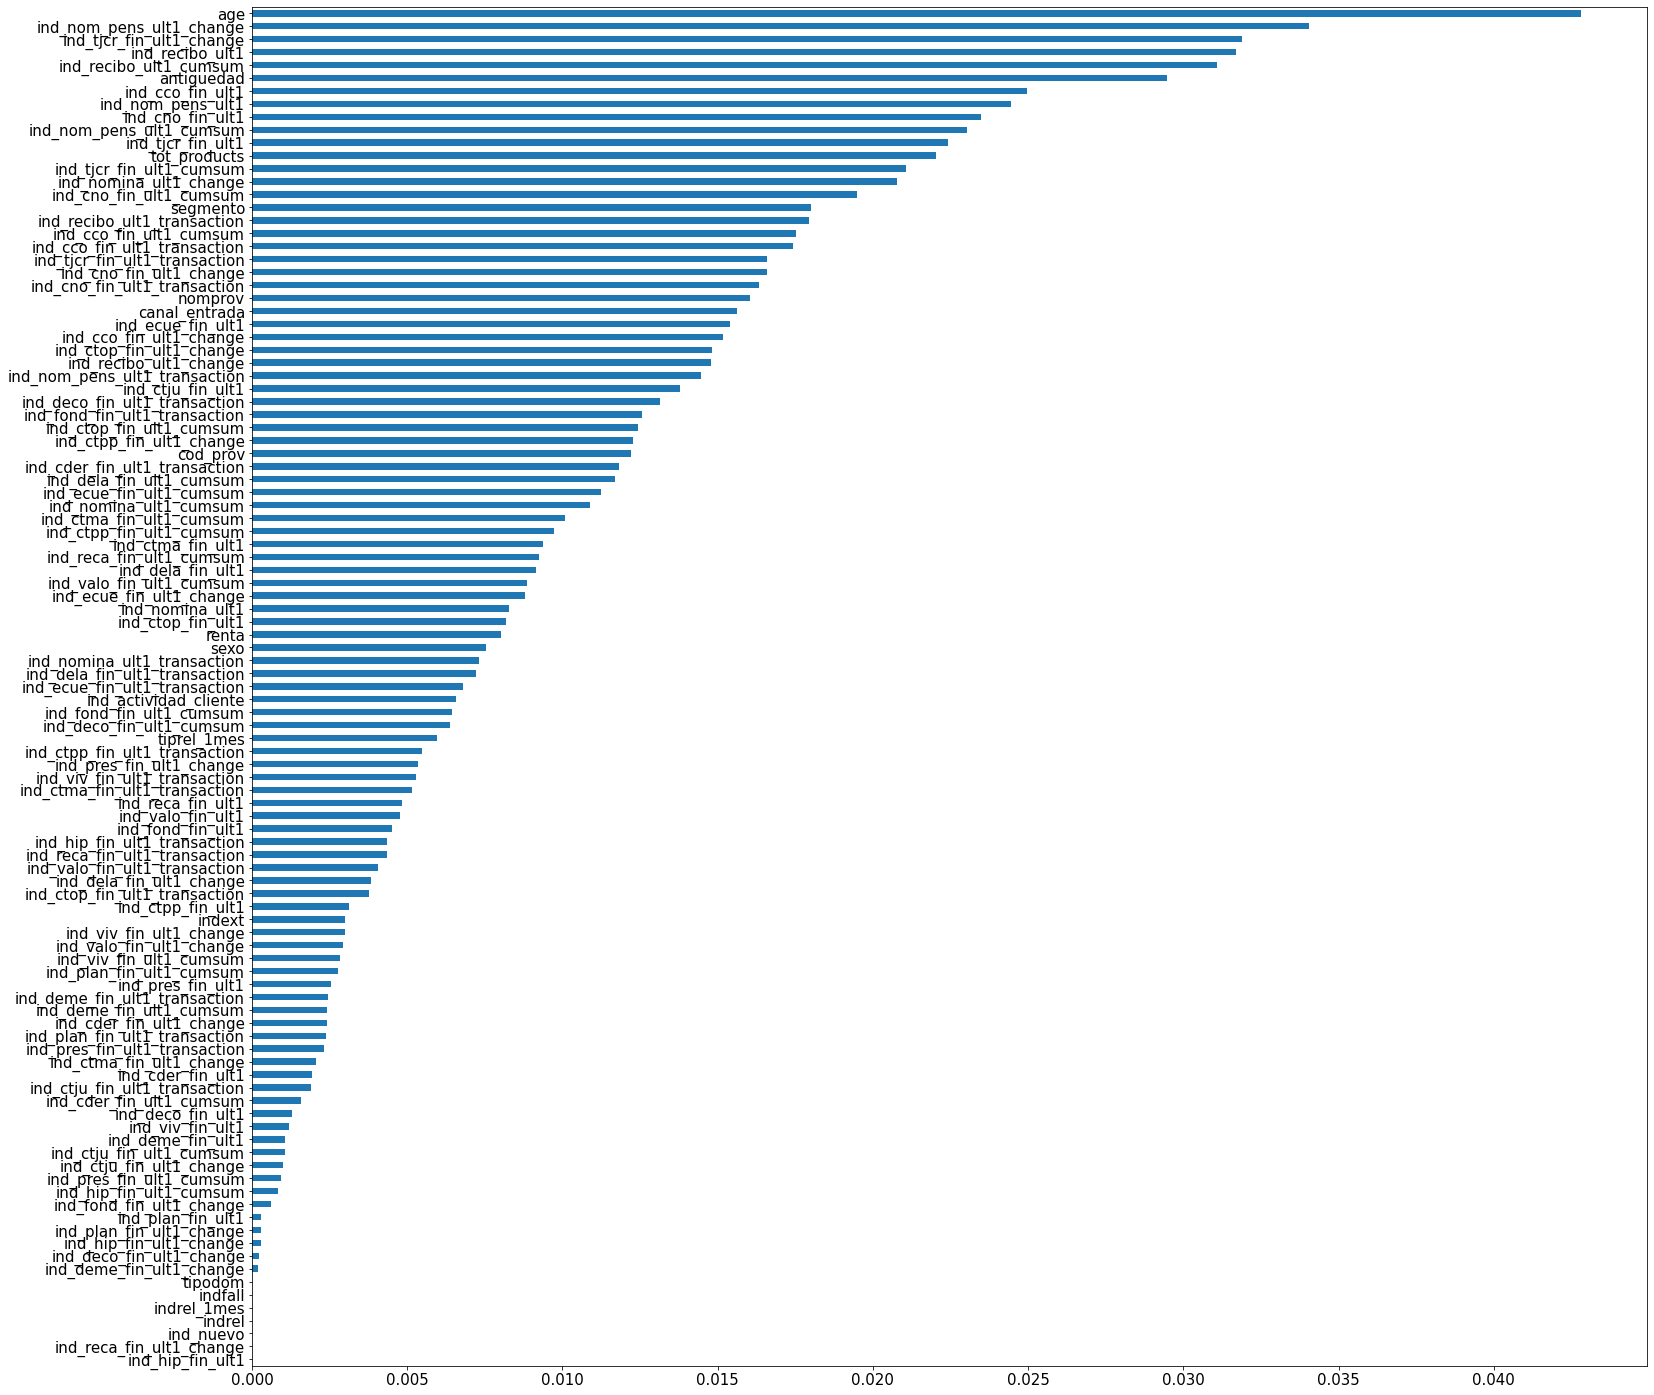

In [ ]:
feat_impts = [] 

for clf in xgboost_classifier.estimators_:
  array_sum = np.sum(clf.feature_importances_)
  array_has_nan = np.isnan(array_sum)
  if np.isnan(array_sum):
    break
  else:
    feat_impts.append(clf.feature_importances_)

feature_importance = pd.Series(np.mean(feat_impts, axis=0), index = x1.columns.values)
feature_importance.sort_values(ascending = True, inplace = True)
feature_importance.plot(kind = "barh", figsize =[25,25], fontsize = 15)

In [ ]:
feature_importance.tail(10)

ind_nom_pens_ult1_cumsum    0.023025
ind_cno_fin_ult1            0.023498
ind_nom_pens_ult1           0.024443
ind_cco_fin_ult1            0.024968
antiguedad                  0.029459
ind_recibo_ult1_cumsum      0.031083
ind_recibo_ult1             0.031704
ind_tjcr_fin_ult1_change    0.031874
ind_nom_pens_ult1_change    0.034054
age                         0.042799
dtype: float32

As we can ses on the plot our most important features are a mix of all features and the created features. In terms of demograhics the **age and seniority** are from significance. That could inidcate that people with  different age have different needs regarding products. For example a 20 year old customer might be less interested in Long-Term deposits, than a credit card. Same goes for seniority, as these might be correlated. Otherwise one might say, that the kinds of products differ for more senior customer, as they might already possess the more basic products. In terms of **change_featuers** the respective feature for pensions is the most important one, follwowed by the payroll accout change. In terms of features, indicating wether a product was activ or not, the respective feature for direct debit and current account holds the most importance. For number of transactions we again see the direct debit feature and the credit card being the most vital ones. For the cumsum feature (i.e total motnhs of being active) we again can observe the direct debit feature and pension. In conclusion, one might infer that the feature importance about the direct debit and pension hold the most information.

### Test Model 2 on Test Set (June)


Having trained the model, it now has to be put into action.We want to generate recommendations which will be sent to  customers of products, who do not have it active. For that, we use our  features for month June as input in the model and recommend the **three** products with highest probability to be bought.   

In [ ]:
#final rank precision top 3 products for june 
##First we predict the output for June Data
y_june = xgboost_classifier.predict(X_june)
##Then we compute the probabilities for each class. In our case we interested in the probability of the output 1 (i.e Product is going to be bought)
june_prob = xgboost_classifier.predict_proba(X_june)

##Now we transform the probabilties to a suitable dataframe with the customeID as the rowIndex and the probabilties per product as the row
df_prob_june = pd.DataFrame()

for i in june_prob:
  a = pd.DataFrame(i)
  a = a[1]
  df_prob_june = pd.concat([df_prob_june,a], axis = 1)  

df_prob_june.index = index
df_prob_june.columns = y_test.columns

## Then we define a function that gets a CustomerId as input and outputs the five products with the highest probabilitz to be bought by the specific customer
def get_recommendation(CustomerID):
  a = df_prob_june.loc[CustomerID]
  return a.sort_values(ascending = False).head(3)

In [ ]:
get_recommendation(268974)

ind_recibo_ult1_activated      0.385981
ind_tjcr_fin_ult1_activated    0.102900
ind_ecue_fin_ult1_activated    0.102481
Name: 268974, dtype: float32

##### Insights: 

Appyling our model to the sample IDs of June, the products with the highest probability to be added to an account (if any) and then really used (remember our Precision Evaluation metric), are **e-account, Credit Card and Direct Debit** (low to high). 

##### Limitations

Potentially to further improve this algorithm and hence thisproject, a more rigorous GridSearch could be performed. Also a more sophisticated scoring metric could be imagined (e.g. Map@7). Also, the feature importance has to be interpreted with a grain of salt since xgBoost is still a black box model. Moreover, another aspect that could be included and that would probably  imprive the model perforamnce would be seasonal trends (e.g. tax months).

# 6. Results

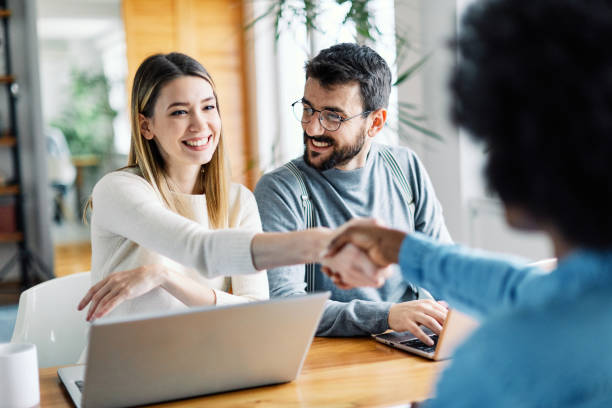

Before coming to a conclusion, let´s revisit our intial problem. Santander needs to do a better job in advertising its products to its customers, so that they are more likely to add and use their services, which should not only provide a better customer experience but also increase revenue. 
We have done this by first looking at the data provided, generating already some disriptive insights. We then prepared the data for machine learning algorithms and constructed new features that might bring insights. We tested different models until we reached one (xgBoost) which not only perfomed accurately in recommending products, but most importantly gave us a high precision for recommending the top 3 products a customer is most likely to add in the next month.

In our EDA (see above), we already found out that 12% of Santander´s customer do not own any products, meaning that they are just signed up, bringing huge potential for our new recommendation algorithm. Further, A third of the customers only own one product, meaning that there is also huge potential to add one or more products to their used services. 

The most important feature, which we also already explored descriptively, is the age of the customer. Most university-aged customers own only one account, which is mostly a current account. On the contrary, middle-aged/elderly people like particular account. Our prediction for June, hence makes sense, in that e-accounts / direct debit /credit card could be interesting in the university-aged customers, while a current account (which is already poular in this group) is not in the top 3. The elder group, as we now from the EDA, largely has particular accounts and has higher seniority, also concluding that those top 3 could be of interest for them.

Thus, it might make sense for the future to build different ML pipelines (for better performance and scale/reusability) for different age groups or customer segments (which Santander already has, namely individual, university, and VIP). Moreover, we have identified different channels for joining, namly KHE (for current account) as well as KAT or KFC (for other accounts), which could already be a starting point for advertising the different products there to the customers.  

All this insghts and predictions, will consequently be very helpful in the goal of Santandar and contribute to recommend the fitting products to the right customer group through different channels.